# Imports

In [ ]:
#!pip uninstall transformers
#!pip uninstall sentencepiece
!pip install transformers
!pip install sentencepiece


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.9 MB/s eta 0:00:00


In [ ]:
# drive access
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

%%capture

import gensim.downloader as api

import nltk
import gensim
import gensim.corpora as corpora
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.coherencemodel import CoherenceModel
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

!pip install --no-cache-dir transformers sentencepiece
#!pip install transformers==3.2.0
#!pip install sentencepiece
!pip install --upgrade accelerate
from transformers import BertTokenizer, TFBertForSequenceClassification


import tensorflow as tf

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=75617583cafca098f2ab0fdd8313d188ffaef1da7052177eb75d8102cab357e6
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


# Preprocessing

## Training Preprocessing

In [ ]:
import pandas as pd
import glob
# Get a list of all Excel files in a directory
file_paths = glob.glob("/content/drive/MyDrive/Subasish/CN_NLP/CN_Files/*.csv")

# Create an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Iterate over each file
for file_path in file_paths:
    # Read the Excel file into a DataFrame
    df = pd.read_csv(file_path, encoding='latin1')

    # Append the data to the combined DataFrame
    combined_df = combined_df.append(df, ignore_index=True)

df = combined_df
df.columns

<ipython-input-5-44dc2af0260d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(df, ignore_index=True)
<ipython-input-5-44dc2af0260d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(df, ignore_index=True)
<ipython-input-5-44dc2af0260d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(df, ignore_index=True)
<ipython-input-5-44dc2af0260d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(df, ignore_index=True)
<ipython-input-5-44dc2af0260d>:15: FutureWarning: The frame.append method is deprecated and will

Index(['Unnamed: 0', 'OBJECTID', 'Narrative', 'CRASH_YR', 'DISTRICT_NBR',
       'NLF_COUNTY_CD', 'ODOT_LATITUDE_NBR', 'ODOT_LONGITUDE_NBR',
       'CRASH_DATE', 'CRASH_SEVERITY_CD', 'CRASH_TYPE_CD', 'DAY_IN_WEEK_CD',
       'DISTRACTED_DRIVER_IND', 'FACILITY_TYPE_CD', 'FHWA_RDWY_DEPARTURE_IND',
       'FREEWAY_IND', 'FUNCTIONAL_CLASS_CD', 'HOUR_OF_CRASH',
       'IS_COMMERCIAL_RELATED', 'LIGHT_COND_PRIMARY_CD', 'MONTH_OF_CRASH',
       'ODOT_DIV_UNDIV_IND', 'ODOT_INTERSECTION_REL_IND', 'ODOT_LANES_NBR',
       'ODPS_MOTORCYCLE_IND', 'ODPS_LOC_IN_WORK_ZONE_CD',
       'ODOT_YOUNG_DRIVER_IND', 'ODPS_SCHOOL_ZONE_IND',
       'ODPS_SENIOR_DRIVER_IND', 'ODPS_SPEED_IND', 'ODPS_TYPE_OF_WORK_ZONE_CD',
       'ODPS_WORK_ZONE_IND', 'OPER_ACCESS_CONTROL_CD', 'ROAD_COND_PRIMARY_CD',
       'SECONDARY_CRASH', 'U1_AGE_NBR', 'U1_AT_FAULT_IND',
       'U1_DISTRACTED_BY_1_CD', 'U1_IS_ALCOHOL_SUSPECTED',
       'U1_IS_MARIJUANA_SUSPECTED', 'U1_OBJECT_STRUCK',
       'U1_OPERATINGIN_AUTONOMOUS_MODE', 'U

In [ ]:
#df = df.sample(frac=0.75, random_state=42)
len(df)

1455607

In [ ]:
df['CRASH_SEVERITY_CD'] = df['CRASH_SEVERITY_CD'].replace('Fatal', 'Serious Injury Suspected')
df['CRASH_SEVERITY_CD'] = df['CRASH_SEVERITY_CD'].replace('Injury Possible', 'Minor Injury Suspected')
df['CRASH_SEVERITY_CD'].value_counts()

Property Damage Only        1072930
Minor Injury Suspected       338803
Serious Injury Suspected      43874
Name: CRASH_SEVERITY_CD, dtype: int64

In [ ]:
# Assuming df is your DataFrame
# Set the number of times you want to run the loop
num_iterations = 3

for _ in range(num_iterations):
    # Filter the rows with 'CRASH_TYPE_CD' equal to 'Property Damage Only'
    property_damage_rows = df[df['CRASH_SEVERITY_CD'] == 'Property Damage Only']

    # Calculate the number of rows to drop (a quarter of the filtered rows)
    num_rows_to_drop = len(property_damage_rows) // 2

    # Randomly drop a quarter of the filtered rows
    property_damage_rows_to_drop = property_damage_rows.sample(n=num_rows_to_drop, random_state=42)
    df = df.drop(property_damage_rows_to_drop.index)

# After the loop, you can check the value counts
print(df['CRASH_SEVERITY_CD'].value_counts())

Minor Injury Suspected      338803
Property Damage Only        134117
Serious Injury Suspected     43874
Name: CRASH_SEVERITY_CD, dtype: int64


In [ ]:
# Assuming df is your DataFrame
# Set the number of times you want to run the loop
num_iterations = 1

for _ in range(num_iterations):
    # Filter the rows with 'CRASH_TYPE_CD' equal to 'Property Damage Only'
    property_damage_rows = df[df['CRASH_SEVERITY_CD'] == 'Property Damage Only']

    # Calculate the number of rows to drop (a quarter of the filtered rows)
    num_rows_to_drop = len(property_damage_rows) // 4
    # Randomly drop a quarter of the filtered rows
    property_damage_rows_to_drop = property_damage_rows.sample(n=num_rows_to_drop, random_state=42)
    df = df.drop(property_damage_rows_to_drop.index)

# After the loop, you can check the value counts
print(df['CRASH_SEVERITY_CD'].value_counts())

Minor Injury Suspected      338803
Property Damage Only        100588
Serious Injury Suspected     43874
Name: CRASH_SEVERITY_CD, dtype: int64


In [ ]:
# Assuming df is your DataFrame
# Set the number of times you want to run the loop
num_iterations = 2

for _ in range(num_iterations):
    # Filter the rows with 'CRASH_TYPE_CD' equal to 'Property Damage Only'
    property_damage_rows = df[df['CRASH_SEVERITY_CD'] == 'Minor Injury Suspected']

    # Calculate the number of rows to drop (a quarter of the filtered rows)
    num_rows_to_drop = len(property_damage_rows) // 2

    # Randomly drop a quarter of the filtered rows
    property_damage_rows_to_drop = property_damage_rows.sample(n=num_rows_to_drop, random_state=42)
    df = df.drop(property_damage_rows_to_drop.index)

# After the loop, you can check the value counts
print(df['CRASH_SEVERITY_CD'].value_counts())

Property Damage Only        100588
Minor Injury Suspected       84701
Serious Injury Suspected     43874
Name: CRASH_SEVERITY_CD, dtype: int64


In [ ]:
# Assuming your DataFrame is named df
class_mapping = {
    'Property Damage Only': 'O',
    'Minor Injury Suspected': 'C',
    'Serious Injury Suspected': 'AB'
}

df['CRASH_SEVERITY_CD'] = df['CRASH_SEVERITY_CD'].replace(class_mapping)


In [ ]:
len(df)

229163

In [ ]:
import re
import string

df['clean_Narrative'] = df['Narrative']
df['clean_Narrative'] = df['clean_Narrative'] .astype(str)
# Define a function to perform replacements
def replace_units(text):
    # Define a regular expression pattern to find instances of 'unit # X' and format as 'unitX'
    text = re.sub(r'unit one', 'unit1', text)
    text = re.sub(r'unit two', 'unit2', text)
    text = re.sub(r'unit three', 'unit3', text)

    text = re.sub(r'unit01', 'unit1', text)
    text = re.sub(r'unit02', 'unit2', text)
    text = re.sub(r'unit03', 'unit3', text)

    # Define a regular expression pattern to match 'unit # X' values and format as 'unitX'
    text = re.sub(r'unit # (\d)', lambda x: f'unit{x.group(1)}', text)

    # Define a regular expression pattern to match 'unit' values and format as 'unitX'
    text = re.sub(r'(?i)(unit) ?#?(\d)', lambda x: f'unit{x.group(2)}', text)

    # Define a regular expression pattern to match the variations and format as 'unitX and unitY'
    text = re.sub(r'(?i)(units?) (\d) and (\d)', lambda x: f'unit{x.group(2)} and unit{x.group(3)}', text)

    return text

# Apply the replacement function to the 'clean_Narrative' column
df['clean_Narrative'] = df['clean_Narrative'].apply(replace_units)


In [ ]:
# remove all variations of directions
patterns_to_remove = [' e\. ', ' s\. ', ' n\.', ' w\. ', ' se ', ' ne ', ' nw ',
                      ' sw ', ' st\. ', ' rd\. ', ' n ', ' w ', ' s ', ' e ',
                      ' sr ', ' eb ', ' sb ', ' nb ', ' wb ',' e/b ', ' s/b ',
                      ' n/b ', ' w/b ', ' e b ', ' s b ', ' n b ', ' w b ', ' ir ', ' av ', ' r ', ' e. ', ' ch ']

# Iterate through the list of patterns and use str.replace() to remove them
for pattern in patterns_to_remove:
    df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, ' ')

#remove whole word directions
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r'\b(north|stbound|south|east|west|southwest|northwest|southeast|northeast|southbound|westbound|northbound|eastbound|bound|sb|eb|nb|wb|th|right|la|hr|hrs|hours|av||hand)\b', '', regex=True)

#remove location ids
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r'\b(?:st|rd|dept|street|streets|hwy|road|street|highway|avenue|ave|block|boulevard|blvd|lane|ln|drive|dr|court|ct|circle|cir|parkway|pkwy|place|pl|junction|jct|route|rt|way)\b','', regex = True)

<ipython-input-14-563cda0862e8>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, ' ')


In [ ]:
# Define a regular expression pattern to match and remove text inside parentheses
pattern = r'\([^)]*\)'

# Use str.replace() to remove instances of 'i-XXXX'
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '')

# Define a regular expression pattern to match 'i-XXXX' where XXX can be any digit from 1 to 4
pattern = r'i-[1-4]'

# Use str.replace() to remove instances of 'i-XXXX'
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '')

# Define a regular expression pattern to match 'i-XXXX' where XXX can be any digit from 1 to 4
pattern = r'i[1-4]'

# Use str.replace() to remove instances of 'i-XXXX'
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '')


# Define a regular expression pattern to match numbers with ordinal suffixes
pattern = r'\b\d{1,4}(?:th|rd|rth|nd|st)\b'

# Use str.replace() to remove numbers with ordinal suffixes
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '')

# Define a regular expression pattern to match the specified pattern
pattern = r'\b[A-Za-z]{2,}\d+[A-Za-z]{2,}\b'

# Use str.replace() to replace the matched pattern with an empty string
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '', regex=True)

# Define a regular expression pattern to match and remove numbers
pattern_remove_numbers = r'\b\d+\b'  # This pattern matches standalone numbers

# Use str.replace() to remove standalone numbers
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern_remove_numbers, '')

# Define a regular expression pattern to match 'unitX' where X is a number
pattern_unit_numbers = r'unit\d'
# Use str.replace() to keep 'unitX' numbers
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern_unit_numbers, lambda x: x.group(0))

# Define a regular expression pattern to remove '#' or '-' or ','
pattern = r'[@#*\-]'

# Use str.replace() to remove the specified characters
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '')

# Define a regular expression pattern to match the specified pattern
pattern = r'\b[A-Za-z]{1,2}\d{1,6}\b'

# Use str.replace() to remove the specified characters
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '')

# Define a regular expression pattern to match the specified pattern
pattern2 = r'[A-Za-z]{2,}\d+[A-Za-z]{2,}'

# Use str.replace() to remove the specified characters
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern2, '')

'''
# Use str.replace() with a regular expression to remove 'r' with spaces around it
df_narr['clean_Narrative'] = df_narr['clean_Narrative'].str.replace(r' r ', ' ')

# Use str.replace() with a regular expression to remove 'r' with spaces around it
df_narr['clean_Narrative'] = df_narr['clean_Narrative'].str.replace(r' b ', ' ')

# Use str.replace() with a regular expression to remove 'r' with spaces around it
df_narr['clean_Narrative'] = df_narr['clean_Narrative'].str.replace(r' n ', ' ')
'''
# Use str.replace() with a regular expression to remove 'r' with spaces around it
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r' am ', ' ')
# Use str.replace() with a regular expression to remove 'r' with spaces around it
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r' pm ', ' ')
# Use str.replace() with a regular expression to remove 'r' with spaces around it
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r' :am ', ' ')
# Use str.replace() with a regular expression to remove 'r' with spaces around it
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r' :pm ', ' ')

# Use str.replace() to delete all '0' characters
df['clean_Narrative'] = df['clean_Narrative'].str.replace('0', '')

'''
# Define a function to remove numbers not preceded by 'unit'
def remove_numbers_not_preceded_by_unit(text):
    # Use str.replace() to remove numbers not preceded by 'unit'
    return text.replace('unit', 'unit ').replace(' unit', '').replace('unit', '').strip()
'''


# Apply the function to the 'clean_Narrative' column
#df_narr['clean_Narrative'] = df_narr['clean_Narrative'].apply(remove_numbers_not_preceded_by_unit)


# Use str.replace() with a regular expression to remove 'r' with spaces around it
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r' // ', ' ')

# Use str.replace() with a regular expression to remove 'r' with spaces around it
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r'/', ' ')

# Use str.replace() with a regular expression to remove 'r' with spaces around it
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r' * ', ' ')

# Use a lambda function to remove '/' characters
#df_narr['clean_Narrative'] = df_narr['clean_Narrative'].apply(lambda x: x.replace('/', ''))



<ipython-input-15-0c9a024d53b7>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '')
<ipython-input-15-0c9a024d53b7>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '')
<ipython-input-15-0c9a024d53b7>:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '')
<ipython-input-15-0c9a024d53b7>:24: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '')
<ipython-input-15-0c9a024d53b7>:36: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_Narrative'] = df['clean_Narrative'].str.replace

In [ ]:
df['clean_Narrative'].iloc[75]

'unit1 advised he was traveling on the roadway and claims to have swerved to miss a deer. which caused him to run off the roadway'

https://github.com/zeraye/names-surnames-list

In [ ]:

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the list of stopwords if you haven't already
nltk.download('punkt')
nltk.download('stopwords')

# Get the list of stopwords
stop_words = set(stopwords.words('english'))


# Function to remove stopwords from a text
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return ' '.join(filtered_tokens)

# Apply the function to the 'clean_Narrative' column
df['clean_Narrative'] = df['clean_Narrative'].apply(remove_stopwords)



In [ ]:
# Define a regular expression pattern to match instances like 'iXXn', 'iXXs', 'iXXw', 'iXXe'
pattern = r'i\d{2}[nswne]'

# Use str.replace() to replace the matched pattern with an empty string
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '', regex=True)

# Define a regular expression pattern to match instances like 'iXXn', 'iXXs', 'iXXw', 'iXXe'
pattern = r'i\d{1}[nswne]'

# Use str.replace() to replace the matched pattern with an empty string
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '', regex=True)

# Define a regular expression pattern to match instances like 'iXXn', 'iXXs', 'iXXw', 'iXXe'
pattern = r'i\d{3}[nswne]'

# Use str.replace() to replace the matched pattern with an empty string
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '', regex=True)

# Remove double spaces
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r'\s+', ' ', regex=True)


In [ ]:
df['Narrative'].iloc[1000]

'unit #1 eastbound on houston hollow-long run road. unit #2 was westbound stationary on houston hollow-candy run road near the intersection attempting to ""winch"" unit ""a"" from a ditch. unit #1 struck the cable that was in it\'s lane of travel which forced unit #2 to spin counter-clockwise causing its\' right side to strike unit #1\'s left side. the cable then stuck the stop sign at the intersection.'

In [ ]:
df['clean_Narrative'].iloc[1000]

"unit1 houston hollowlong run . unit2 stationary houston hollowcandy run near intersection attempting `` '' winch '' '' unit `` '' '' '' ditch . unit1 struck cable 's travel forced unit2 spin counterclockwise causing ' side strike unit1 's left side . cable stuck stop sign intersection ."

In [ ]:
# Count the number of words in each row
word_counts = df['clean_Narrative'].apply(lambda x: len(x.split()))

# Filter rows with at least 10 words
df = df[word_counts >= 10]

In [ ]:
#len(df_narr)
# Remove duplicates from the 'clean_Narrative' column
#df_narr['clean_Narrative'] = df_narr['clean_Narrative'].drop_duplicates(keep='first')
len(df)

215523

In [ ]:
df.to_csv('/content/drive/MyDrive/Subasish/CN_NLP/CN_Hydro_Train.csv')

## Inference Preprocessing

In [ ]:
import pandas as pd
df_pred =pd.read_csv('/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/HydroplanningCrash.csv', encoding='ISO-8859-1')
#df_pred.replace({'CRASH_SEVERITY_CD': {'B': 'AB'}}, inplace=True)
df_pred['CRASH_SEVERITY_CD'].value_counts()


O     1389
AB     326
C      235
Name: CRASH_SEVERITY_CD, dtype: int64

In [ ]:
len(df_pred)

1950

In [ ]:
import re
import string

df_pred['clean_Narrative'] = df_pred['Narrative']
df_pred['clean_Narrative'] = df_pred['clean_Narrative'] .astype(str)
# Define a function to perform replacements
def replace_units(text):
    # Define a regular expression pattern to find instances of 'unit # X' and format as 'unitX'
    text = re.sub(r'unit one', 'unit1', text)
    text = re.sub(r'unit two', 'unit2', text)
    text = re.sub(r'unit three', 'unit3', text)

    text = re.sub(r'unit01', 'unit1', text)
    text = re.sub(r'unit02', 'unit2', text)
    text = re.sub(r'unit03', 'unit3', text)

    # Define a regular expression pattern to match 'unit # X' values and format as 'unitX'
    text = re.sub(r'unit # (\d)', lambda x: f'unit{x.group(1)}', text)

    # Define a regular expression pattern to match 'unit' values and format as 'unitX'
    text = re.sub(r'(?i)(unit) ?#?(\d)', lambda x: f'unit{x.group(2)}', text)

    # Define a regular expression pattern to match the variations and format as 'unitX and unitY'
    text = re.sub(r'(?i)(units?) (\d) and (\d)', lambda x: f'unit{x.group(2)} and unit{x.group(3)}', text)

    return text

# Apply the replacement function to the 'clean_Narrative' column
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].apply(replace_units)


In [ ]:
# remove all variations of directions
patterns_to_remove = [' e\. ', ' s\. ', ' n\.', ' w\. ', ' se ', ' ne ', ' nw ',
                      ' sw ', ' st\. ', ' rd\. ', ' n ', ' w ', ' s ', ' e ',
                      ' sr ', ' eb ', ' sb ', ' nb ', ' wb ',' e/b ', ' s/b ',
                      ' n/b ', ' w/b ', ' e b ', ' s b ', ' n b ', ' w b ', ' ir ', ' av ', ' r ', ' e. ', ' ch ']

# Iterate through the list of patterns and use str.replace() to remove them
for pattern in patterns_to_remove:
    df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(pattern, ' ')

#remove whole word directions
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(r'\b(north|stbound|south|east|west|southwest|northwest|southeast|northeast|southbound|westbound|northbound|eastbound|bound|sb|eb|nb|wb|th|right|la|hr|hrs|hours|av||hand)\b', '', regex=True)

#remove location ids
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(r'\b(?:st|rd|dept|street|streets|hwy|road|street|highway|avenue|ave|block|boulevard|blvd|lane|ln|drive|dr|court|ct|circle|cir|parkway|pkwy|place|pl|junction|jct|route|rt|way)\b','', regex = True)

<ipython-input-268-9f315cb0ee8e>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(pattern, ' ')


In [ ]:
# Define a regular expression pattern to match and remove text inside parentheses
pattern = r'\([^)]*\)'

# Use str.replace() to remove instances of 'i-XXXX'
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(pattern, '')

# Define a regular expression pattern to match 'i-XXXX' where XXX can be any digit from 1 to 4
pattern = r'i-[1-4]'

# Use str.replace() to remove instances of 'i-XXXX'
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(pattern, '')

# Define a regular expression pattern to match 'i-XXXX' where XXX can be any digit from 1 to 4
pattern = r'i[1-4]'

# Use str.replace() to remove instances of 'i-XXXX'
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(pattern, '')


# Define a regular expression pattern to match numbers with ordinal suffixes
pattern = r'\b\d{1,4}(?:th|rd|rth|nd|st)\b'

# Use str.replace() to remove numbers with ordinal suffixes
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(pattern, '')

# Define a regular expression pattern to match the specified pattern
pattern = r'\b[A-Za-z]{2,}\d+[A-Za-z]{2,}\b'

# Use str.replace() to replace the matched pattern with an empty string
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(pattern, '', regex=True)

# Define a regular expression pattern to match and remove numbers
pattern_remove_numbers = r'\b\d+\b'  # This pattern matches standalone numbers

# Use str.replace() to remove standalone numbers
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(pattern_remove_numbers, '')

# Define a regular expression pattern to match 'unitX' where X is a number
pattern_unit_numbers = r'unit\d'
# Use str.replace() to keep 'unitX' numbers
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(pattern_unit_numbers, lambda x: x.group(0))

# Define a regular expression pattern to remove '#' or '-' or ','
pattern = r'[@#*\-]'

# Use str.replace() to remove the specified characters
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(pattern, '')

# Define a regular expression pattern to match the specified pattern
pattern = r'\b[A-Za-z]{1,2}\d{1,6}\b'

# Use str.replace() to remove the specified characters
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(pattern, '')

# Define a regular expression pattern to match the specified pattern
pattern2 = r'[A-Za-z]{2,}\d+[A-Za-z]{2,}'

# Use str.replace() to remove the specified characters
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(pattern2, '')

'''
# Use str.replace() with a regular expression to remove 'r' with spaces around it
df_narr['clean_Narrative'] = df_narr['clean_Narrative'].str.replace(r' r ', ' ')

# Use str.replace() with a regular expression to remove 'r' with spaces around it
df_narr['clean_Narrative'] = df_narr['clean_Narrative'].str.replace(r' b ', ' ')

# Use str.replace() with a regular expression to remove 'r' with spaces around it
df_narr['clean_Narrative'] = df_narr['clean_Narrative'].str.replace(r' n ', ' ')
'''
# Use str.replace() with a regular expression to remove 'r' with spaces around it
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(r' am ', ' ')
# Use str.replace() with a regular expression to remove 'r' with spaces around it
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(r' pm ', ' ')
# Use str.replace() with a regular expression to remove 'r' with spaces around it
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(r' :am ', ' ')
# Use str.replace() with a regular expression to remove 'r' with spaces around it
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(r' :pm ', ' ')

# Use str.replace() to delete all '0' characters
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace('0', '')

'''
# Define a function to remove numbers not preceded by 'unit'
def remove_numbers_not_preceded_by_unit(text):
    # Use str.replace() to remove numbers not preceded by 'unit'
    return text.replace('unit', 'unit ').replace(' unit', '').replace('unit', '').strip()
'''


# Apply the function to the 'clean_Narrative' column
#df_narr['clean_Narrative'] = df_narr['clean_Narrative'].apply(remove_numbers_not_preceded_by_unit)


# Use str.replace() with a regular expression to remove 'r' with spaces around it
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(r' // ', ' ')

# Use str.replace() with a regular expression to remove 'r' with spaces around it
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(r'/', ' ')

# Use str.replace() with a regular expression to remove 'r' with spaces around it
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(r' * ', ' ')

# Use a lambda function to remove '/' characters
#df_narr['clean_Narrative'] = df_narr['clean_Narrative'].apply(lambda x: x.replace('/', ''))



<ipython-input-269-a99615430a1d>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(pattern, '')
<ipython-input-269-a99615430a1d>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(pattern, '')
<ipython-input-269-a99615430a1d>:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(pattern, '')
<ipython-input-269-a99615430a1d>:24: FutureWarning: The default value of regex will change from True to False in a future version.
  df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(pattern, '')
<ipython-input-269-a99615430a1d>:36: FutureWarning: The default value of regex will change from True to False in a future version.
  df_pred['cle

In [ ]:
df_pred['clean_Narrative'].iloc[75]

"unit2 was traveling on oakland park and came to a stop preparing to turn left onto oaklawn unit1 was directly behind unit2. unit1 failed to maintain assured clear distance ahead, striking unit2 in the rear. the driver of unit1 stated due to the rainy and wet conditions her vehicle hydroplaned. the driver of unit1 was determined to be at fault and was cited for . acda. the driver of unit1 also had a suspended license and was cited accordingly. the front passenger of unit2 was transported to children's hospital by cfd medic where she was treated by staff for neck pain. no other injuries reported. unit2 was towed per the owner by a&e towing. unit1 was impounded to the cpd impount lot by maynard's towing."

https://github.com/zeraye/names-surnames-list

In [ ]:

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the list of stopwords if you haven't already
nltk.download('punkt')
nltk.download('stopwords')

# Get the list of stopwords
stop_words = set(stopwords.words('english'))


# Function to remove stopwords from a text
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return ' '.join(filtered_tokens)

# Apply the function to the 'clean_Narrative' column
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].apply(remove_stopwords)



In [ ]:
# Define a regular expression pattern to match instances like 'iXXn', 'iXXs', 'iXXw', 'iXXe'
pattern = r'i\d{2}[nswne]'

# Use str.replace() to replace the matched pattern with an empty string
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(pattern, '', regex=True)

# Define a regular expression pattern to match instances like 'iXXn', 'iXXs', 'iXXw', 'iXXe'
pattern = r'i\d{1}[nswne]'

# Use str.replace() to replace the matched pattern with an empty string
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(pattern, '', regex=True)

# Define a regular expression pattern to match instances like 'iXXn', 'iXXs', 'iXXw', 'iXXe'
pattern = r'i\d{3}[nswne]'

# Use str.replace() to replace the matched pattern with an empty string
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(pattern, '', regex=True)

# Remove double spaces
df_pred['clean_Narrative'] = df_pred['clean_Narrative'].str.replace(r'\s+', ' ', regex=True)


In [ ]:
df_pred['Narrative'].iloc[1000]

'unit 1 was traveling southbound on the entrance ramp to interstate route 75 from state route 309. unit 2 was traveling southbound on interstate route 75 in the right lane. unit 1 stated he hydroplaned and lost control and struck unit 2, causing unit 2 to spin out and get struck a second time by unit 1. unit 2 then struck the guardrail.'

In [ ]:
df_pred['clean_Narrative'].iloc[1000]

'unit1 traveling entrance ramp interstate state . unit2 traveling interstate . unit1 stated hydroplaned lost control struck unit2 , causing unit2 spin get struck second time unit1 . unit2 struck guardrail .'

In [ ]:
#len(df_narr)
# Remove duplicates from the 'clean_Narrative' column
#df_narr['clean_Narrative'] = df_narr['clean_Narrative'].drop_duplicates(keep='first')
len(df)

129314

In [ ]:
df_pred.to_csv('/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/Hydro_Inf.csv')

# BERT

### Prep

#### Preprocess

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the datasets
df = pd.read_csv('/content/drive/MyDrive/Subasish/CN_NLP/CN_Hydro_Train.csv', encoding='latin1')
df = df.sample(frac=0.6, random_state=45)
df_pred = pd.read_csv('/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/Hydro_Inf.csv', encoding='ISO-8859-1')

# Split the train set into train and validation sets
train, valid = train_test_split(df, test_size=0.25, shuffle=True, random_state=42)

# Use df_pred as the test set
test = df_pred.copy()

# Extract features and labels for train set
x_train = train[["clean_Narrative"]]
y_train = train[["CRASH_SEVERITY_CD"]]

# Extract features and labels for validation set
x_valid = valid[["clean_Narrative"]]
y_valid = valid[["CRASH_SEVERITY_CD"]]

# Extract features and labels for test set
x_test = test[["clean_Narrative"]]
y_test = test[["CRASH_SEVERITY_CD"]]

# Display the shapes of the sets
print("Train set shape:", train.shape)
print("Validation set shape:", valid.shape)
print("Test set shape:", test.shape)


Train set shape: (96985, 53)
Validation set shape: (32329, 53)
Test set shape: (1950, 152)


In [ ]:
y_train.value_counts()

CRASH_SEVERITY_CD
O                    41304
C                    36597
AB                   19084
dtype: int64

In [ ]:
y_valid.value_counts()

CRASH_SEVERITY_CD
O                    13964
C                    12034
AB                    6331
dtype: int64

In [ ]:
y_test.value_counts()

CRASH_SEVERITY_CD
O                    1389
AB                    326
C                     235
dtype: int64

In [ ]:
'''
seqlen = x_train["clean_Narrative"].apply(lambda x: len(x.split()))

sns.set_style("darkgrid")
plt.figure(figsize=(8,5))
sns.distplot(seqlen)
'''

'\nseqlen = x_train["clean_Narrative"].apply(lambda x: len(x.split()))\n\nsns.set_style("darkgrid")\nplt.figure(figsize=(8,5))\nsns.distplot(seqlen)\n'

In [ ]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
          '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
          '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
          '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
          '∙', ')', '↓', '、', '│', '(', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]


def preprocess_text(text):
    def clean_text(x):
        x = str(x)
        for punct in puncts:
            if punct in x:
                x = x.replace(punct, f' {punct} ')
        return x

    def clean_numbers(x):
        if bool(re.search(r'\d', x)):
            x = re.sub('[0-9]{5,}', '#####', x)
            x = re.sub('[0-9]{4}', '####', x)
            x = re.sub('[0-9]{3}', '###', x)
            x = re.sub('[0-9]{2}', '##', x)
        return x

    #text = text.lower()
    text = clean_text(text)
    text = clean_numbers(text)

    return text

In [ ]:
def preprocess_text(text):
    # Lower and clean text
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # Remove double spaces

    return text

def preprocess(df, text_col_name):
    # Lower and clean text
    df[text_col_name] = df[text_col_name].apply(lambda x: preprocess_text(x))

    # Fill up the missing values
    df[text_col_name] = df[text_col_name].fillna("_##_")

    return df


In [ ]:

x_train = preprocess(x_train.copy(), "clean_Narrative")
x_valid = preprocess(x_valid.copy(), "clean_Narrative")

print(x_train.head())

                                          clean_Narrative
176375  unit1 traveling traveled left side roadway str...
94983   unit1 traveling roosevelt jackson . rear drive...
13938   unit1 traveling elm unit2 motor vehicle parked...
161436  unit1 traveling westwood northern bv high rate...
141081  unit1 traveling , defiance williams county lin...


#### Model setup

In [ ]:
import itertools
import tensorflow as tf
from transformers import TFBertModel
from tensorflow.keras.layers import Input, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Model
from transformers.optimization_tf import AdamWeightDecay
### HERE
SEQ_LEN = 175

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Load the BERT base model
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Tokenize the input
input_ids = Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
mask = Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')
inputs = [input_ids, mask]

# Use the entire BERT model for sequence classification
bert_output = bert_model(input_ids, attention_mask=mask)
pooled_output = bert_output.pooler_output  # Get the pooled output

# Additional layers
dropout_rate = 0.1
dense_units = 512
X = Dropout(dropout_rate)(pooled_output)
X = Dense(dense_units, activation='relu')(X)
X = Dense(dense_units, activation='relu')(X)
X = Dense(256, activation='relu')(X)

# Output layer
output_units = 3
outputs = Dense(output_units, activation='softmax', name='outputs')(X)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Fine-tune BERT layers
for layer in bert_model.layers:
    layer.trainable = True

# Print model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 175)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 175)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 175, 7                                       

In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer
from joblib import Parallel, delayed




# Function to tokenize a batch of texts
def tokenize_batch(texts):
    tokens = tokenizer(texts, max_length=SEQ_LEN,
                       truncation=True, padding='max_length',
                       add_special_tokens=True, return_attention_mask=True,
                       return_token_type_ids=False, return_tensors='tf')
    return tokens["input_ids"], tokens["attention_mask"]

# Function to tokenize a single text (deprecated)
def tokenize_text(text):
    return tokenize_batch([text])

# Function to tokenize a DataFrame
def tokenize_dataframe(df):
    texts = df["clean_Narrative"].tolist()

    # Tokenize in batches
    results = Parallel(n_jobs=-1)(delayed(tokenize_batch)(texts[i:i+batch_size]) for i in range(0, len(texts), batch_size))

    input_ids, attention_masks = zip(*results)
    return (tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0))

# Example usage
batch_size = 32  # Adjust batch size as needed
train_input_ids, train_attention_masks = tokenize_dataframe(x_train)
valid_input_ids, valid_attention_masks = tokenize_dataframe(x_valid)

print(train_input_ids[0])

tf.Tensor(
[  101  3131  2487  7118  6158  2187  2217 18799  8478  8638  3384  2695
  1012   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

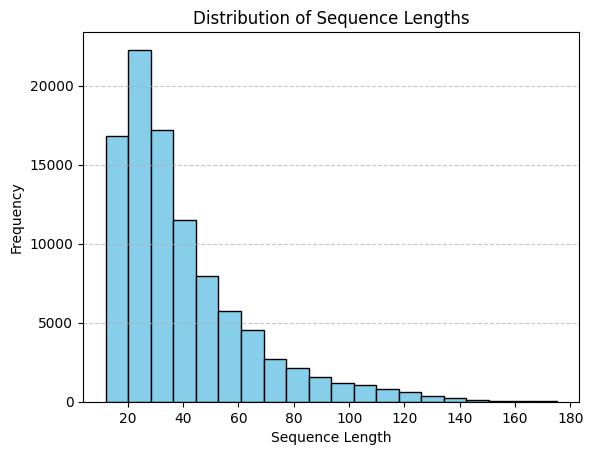

In [ ]:
import matplotlib.pyplot as plt

# Calculate the sequence lengths (assuming you haven't done it already)
sequence_lengths = [tf.reduce_sum(tf.cast(train_attention_masks[i], tf.int32)).numpy() for i in range(len(train_input_ids))]

# Create a histogram of sequence lengths
plt.hist(sequence_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [ ]:

def one_encode_labels(df):
    topic_values = ['O','C','AB']
    labels = []
    for index, row in df.iterrows():
        topic = row["CRASH_SEVERITY_CD"]
        if topic in topic_values:
            label = np.zeros((len(topic_values)))
            label[topic_values.index(topic)] = 1
            labels.append(label)
        else:
            # Handle invalid or missing sentiment values (e.g., log the error or skip the data point)
            print(f"Invalid sentiment value '{topic}' at index {index}. Skipping this data point.")
            # Alternatively, you can raise an exception if you want to halt the process.
            # raise ValueError(f"Invalid sentiment value '{sentiment}' at index {index}.")
    labels = np.asarray(labels)
    return labels



In [ ]:
print("Unique values in y_train sentiment column:", y_train['CRASH_SEVERITY_CD'].unique())
print("Unique values in y_valid sentiment column:", y_valid['CRASH_SEVERITY_CD'].unique())



Unique values in y_train sentiment column: ['O' 'AB' 'C']
Unique values in y_valid sentiment column: ['AB' 'C' 'O']


In [ ]:
y_train['CRASH_SEVERITY_CD']

176375     O
94983      O
13938     AB
161436    AB
141081     O
          ..
1080       O
3013       O
101204     C
207760     O
62869      O
Name: CRASH_SEVERITY_CD, Length: 96985, dtype: object

In [ ]:
y_train['CRASH_SEVERITY_CD'].value_counts()

O     41304
C     36597
AB    19084
Name: CRASH_SEVERITY_CD, dtype: int64

In [ ]:
# Map sentiment labels to integer values (assuming 'negative': 0, 'neutral': 1, 'positive': 2)
#sentiment_mapping = {'Property Damage Only': 0, 'Injury Possible': 1, 'Minor Injury Suspected': 2, 'Serious Injury Suspected' : 3, 'Fatal': 4}
sentiment_mapping = {'O': 0, 'C': 1, 'AB' : 2 }
# Print the mapping
print(sentiment_mapping)



# Convert the labels to integers using the mapping
y_train['CRASH_SEVERITY_CD'] = y_train['CRASH_SEVERITY_CD'].apply(lambda label: sentiment_mapping[label])
y_valid['CRASH_SEVERITY_CD'] = y_valid['CRASH_SEVERITY_CD'].apply(lambda label: sentiment_mapping[label])

# One-hot encode the integer labels
y_train_one_hot = tf.keras.utils.to_categorical(y_train['CRASH_SEVERITY_CD'], num_classes=3)
y_valid_one_hot = tf.keras.utils.to_categorical(y_valid['CRASH_SEVERITY_CD'], num_classes=3)



{'O': 0, 'C': 1, 'AB': 2}


<ipython-input-18-ada33b6ced1e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['CRASH_SEVERITY_CD'] = y_train['CRASH_SEVERITY_CD'].apply(lambda label: sentiment_mapping[label])
<ipython-input-18-ada33b6ced1e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_valid['CRASH_SEVERITY_CD'] = y_valid['CRASH_SEVERITY_CD'].apply(lambda label: sentiment_mapping[label])


In [ ]:
y_train_one_hot.shape

(96985, 3)

In [ ]:
y_valid_one_hot.shape

(32329, 3)

## Model containers

In [ ]:
import itertools
import tensorflow as tf
from transformers import TFBertModel
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

bert_models = []
bert_histories = []
bert_configurations = []  # To store the batch size and loss function for each model
y_true_list = []
y_probs_list = []

## Model 1: BS - 64, Loss - BCE

In [ ]:
import itertools
import tensorflow as tf
from transformers import TFBertModel
from tensorflow.keras.layers import Input
from transformers.optimization_tf import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the learning rate schedule function
def lr_schedule(epoch):
    initial_lr = 2e-05  # Initial learning rate
    decay = 0.95  # Decay rate
    if epoch < 5:
        return initial_lr
    else:
        return initial_lr * (decay ** (epoch - 5))

# Define the different combinations of batch size and loss function
batch_sizes = [64]
loss_functions = [tf.keras.losses.BinaryCrossentropy()]

# Enable mixed precision training
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Enable XLA
tf.config.optimizer.set_jit(True)

# Create a single loop that iterates over all combinations of batch sizes and loss functions
combinations = list(itertools.product(batch_sizes, loss_functions))
for batch_size, loss_function in combinations:
    bert_model = TFBertModel.from_pretrained("bert-base-uncased")
    input_ids = Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
    mask = Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

    embeddings = bert_model(input_ids, attention_mask=mask)[0]

    optimizer = Adam(2e-05, beta_1=0.8, beta_2=0.9)

    # Compile the model with mixed precision optimizer
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

    # Use tf.data.Dataset to create efficient data pipelines
    train_dataset = tf.data.Dataset.from_tensor_slices(((train_input_ids, train_attention_masks), y_train_one_hot))
    train_dataset = train_dataset.batch(batch_size)

    valid_dataset = tf.data.Dataset.from_tensor_slices(((valid_input_ids, valid_attention_masks), y_valid_one_hot))
    valid_dataset = valid_dataset.batch(batch_size)

    # Define the learning rate scheduler
    lr_scheduler = LearningRateScheduler(lr_schedule)

    # Train the model using vectorized data pipeline and the learning rate scheduler
    history = model.fit(train_dataset, validation_data=valid_dataset, epochs=8, callbacks=[lr_scheduler])

    bert_models.append(model)
    bert_histories.append(history)

    # Save the configuration (batch size and loss function) used for this model
    bert_configurations.append((batch_size, loss_function))

    # Get true labels and predicted probabilities for the validation set using vectorized prediction
    y_true = y_valid_one_hot
    y_probs = model.predict(valid_dataset)

    y_true_list.append(y_true)
    y_probs_list.append(y_probs)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture

Epoch 1/8
1516/1516 [==============================] - 307s 172ms/step - loss: 0.4890 - accuracy: 0.6014 - val_loss: 0.4586 - val_accuracy: 0.6329 - lr: 2.0000e-05
Epoch 2/8
1516/1516 [==============================] - 268s 177ms/step - loss: 0.4424 - accuracy: 0.6503 - val_loss: 0.4598 - val_accuracy: 0.6409 - lr: 2.0000e-05
Epoch 3/8
1516/1516 [==============================] - 249s 164ms/step - loss: 0.4130 - accuracy: 0.6805 - val_loss: 0.4649 - val_accuracy: 0.6437 - lr: 2.0000e-05
Epoch 4/8
1516/1516 [==============================] - 249s 164ms/step - loss: 0.3815 - accuracy: 0.7098 - val_loss: 0.4887 - val_accuracy: 0.6471 - lr: 2.0000e-05
Epoch 5/8
1516/1516 [==============================] - 249s 164ms/step - loss: 0.3497 - accuracy: 0.7417 - val_loss: 0.5329 - val_accuracy: 0.6471 - lr: 2.0000e-05
Epoch 6/8
1516/1516 [==============================] - 249s 164ms/step - loss: 0.3200 - accuracy: 0.7674 - val_loss: 0.5597 - val_accuracy: 0.6477 - lr: 2.0000e-05
Epoch 7/8
1516/1

### Predictions

In [ ]:
import pandas as pd
import numpy as np
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Story_list = df_pred['clean_Narrative'].astype(str).tolist()

# Tokenize and encode the Story using the tokenizer
encoded_texts = tokenizer.batch_encode_plus(Story_list, truncation=True, padding=True, return_tensors="tf")

# Define the maximum sequence length expected by the BERT model
max_sequence_length = 175

# Pad or truncate sequences to match the expected input size
input_ids = pad_sequences(encoded_texts["input_ids"], maxlen=max_sequence_length, padding="post", truncating="post")
attention_mask = pad_sequences(encoded_texts["attention_mask"], maxlen=max_sequence_length, padding="post", truncating="post")

# Choose a trained BERT model from the bert_models list
chosen_model_index = 0  # Choose the index of the desired model from bert_models list
chosen_model = bert_models[chosen_model_index]

# Predict using the chosen BERT model
y_probs_bert = chosen_model.predict((input_ids, attention_mask))

# Assuming y_probs_bert has shape (num_samples, num_classes)
# Store the predicted sentiment labels
df_pred['BERT_predictions'] = y_probs_bert.argmax(axis=1)

# Convert prediction probabilities to a string representation and store in a column
df_pred['BERT_prediction_probabilities'] = y_probs_bert.tolist()


61/61 [==============================] - 8s 36ms/step


In [ ]:
sentiment_mapping = {'O': 0, 'C': 1, 'AB' : 2 }
# Print the mapping
print(sentiment_mapping)



# Convert the labels to integers using the mapping
df_pred['CRASH_SEVERITY_CD'] = df_pred['CRASH_SEVERITY_CD'].apply(lambda label: sentiment_mapping[label])


{'O': 0, 'C': 1, 'AB': 2}


In [ ]:
df_pred['BERT_predictions'].value_counts()

0    1419
1     480
2      51
Name: BERT_predictions, dtype: int64

In [ ]:
df_pred['CRASH_SEVERITY_CD'].value_counts()

0    1389
2     326
1     235
Name: CRASH_SEVERITY_CD, dtype: int64

In [ ]:
df_pred['BERT_predictions'].iloc[120]


0

In [ ]:
df_pred['CRASH_SEVERITY_CD'].iloc[120]

0

In [ ]:

# Save the DataFrame to an Excel file
df_pred.to_csv('/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/Crash_predictions_bert.csv', index=False)

#### LIME

In [ ]:
import pandas as pd
import numpy as np
from lime.lime_text import LimeTextExplainer

# Define class names and their corresponding integer indices
class_names = ["O", "C", "AB"]
class_indices = {class_name: index for index, class_name in enumerate(class_names)}

Story_list = df_pred['clean_Narrative'].astype(str).tolist()

# Extract the predicted probabilities for each class
predicted_probabilities = df_pred['BERT_prediction_probabilities']

# Choose a trained BERT model from the bert_models list
chosen_model_index = 0  # Choose the index of the desired model from bert_models list
chosen_model = bert_models[chosen_model_index]

# Create a LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

# Loop through each class in class_names
for class_name in class_names:
    # Find the top 10 predictions with the highest probability for the current class
    top_k_indices = np.argsort([probs[class_indices[class_name]] for probs in predicted_probabilities])[-10:]

    # Loop through the top 10 predictions and generate explanations
    for i, sample_index in enumerate(top_k_indices):
        # Replace 'O' with the current class name
        output_file_path = f'/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/LIME/BERT_{class_name}_LIME_{i + 1}.html'

        # Define a custom predict function that takes text input and returns class probabilities
        def custom_predict(texts):
            # Tokenize and preprocess the texts (similar to your code above)
            encoded_texts = tokenizer.batch_encode_plus(texts, truncation=True, padding=True, return_tensors="tf")
            input_ids = encoded_texts["input_ids"]
            attention_mask = encoded_texts["attention_mask"]

            # Predict using the chosen BERT model
            y_probs_bert = chosen_model.predict((input_ids, attention_mask))

            return y_probs_bert

        # Explain the prediction with the highest probability for the current class
        explanation = explainer.explain_instance(
            Story_list[sample_index],
            custom_predict,  # Pass the custom predict function
            labels=[class_indices[class_name]]
        )

        # Save each explanation to a separate HTML file
        explanation.save_to_file(output_file_path)

        # Display the explanations in the notebook
        print(f"Explanation for BERT_{class_name}_LIME_{i + 1}:")
        # explanation.show_in_notebook(text=True)


157/157 [==============================] - 4s 24ms/step
Explanation for BERT_O_LIME_1:
157/157 [==============================] - 3s 22ms/step
Explanation for BERT_O_LIME_2:
157/157 [==============================] - 4s 23ms/step
Explanation for BERT_O_LIME_3:
157/157 [==============================] - 4s 23ms/step
Explanation for BERT_O_LIME_4:
157/157 [==============================] - 1s 8ms/step
Explanation for BERT_O_LIME_5:
157/157 [==============================] - 4s 27ms/step
Explanation for BERT_O_LIME_6:
157/157 [==============================] - 4s 25ms/step
Explanation for BERT_O_LIME_7:
157/157 [==============================] - 5s 30ms/step
Explanation for BERT_O_LIME_8:
157/157 [==============================] - 4s 24ms/step
Explanation for BERT_O_LIME_9:
157/157 [==============================] - 4s 28ms/step
Explanation for BERT_O_LIME_10:
157/157 [==============================] - 4s 28ms/step
Explanation for BERT_C_LIME_1:
157/157 [==============================] - 

#### Accuracy

In [ ]:
# Assuming you have the DataFrame 'df' with 'BERT_sent_Best' and 'CRASH_SEVERITY_CD' columns

# Calculate the accuracy
correct_predictions = df_pred['BERT_predictions'] == df_pred['CRASH_SEVERITY_CD']
accuracy = correct_predictions.mean() * 100

print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 68.67%


In [ ]:
df_pred.columns

Index(['Unnamed: 0', 'OBJECTID', 'Narrative', 'DOCUMENT_NBR', 'CRASH_YR',
       'CRASH_SEVERITY_CD', 'CRASH_MONTH_YEAR', 'DISTRICT_NBR', 'NLFID',
       'NLF_JUR_CD',
       ...
       'U3_SEQ_OF_EVENTS_6_CD', 'U3_SPECIAL_FUNCTION_CD',
       'U3_TRAFFIC_CONTROL_CD', 'U3_TYPE_OF_UNIT_CD', 'UNRESTRAIN_OCCUPANTS',
       'WEATHER_COND_CD', 'V1', 'clean_Narrative', 'BERT_predictions',
       'BERT_prediction_probabilities'],
      dtype='object', length=154)

In [ ]:
df_pred['BERT_predictions'].value_counts()

0    1419
1     480
2      51
Name: BERT_predictions, dtype: int64

In [ ]:
df_pred['CRASH_SEVERITY_CD'].value_counts()

0    1389
2     326
1     235
Name: CRASH_SEVERITY_CD, dtype: int64

## Plot ROC

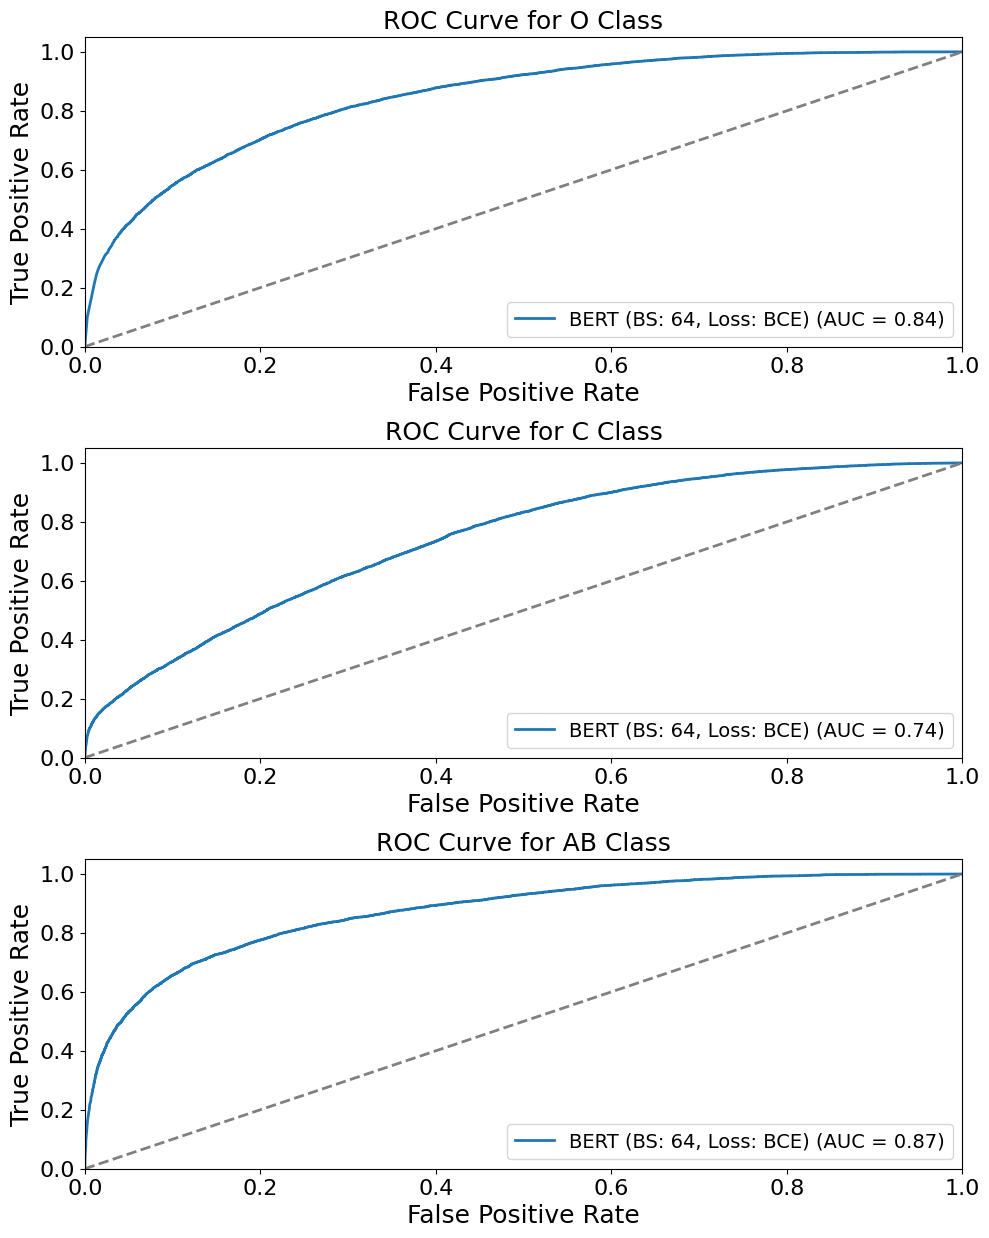

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to plot the ROC curves
def plot_roc_curve_per_class(y_true_list, y_probs_list, bert_configurations, class_names):
    plt.figure(figsize=(10, 16))  # Adjust the figure size to accommodate vertically stacked subplots

    for i in range(3):  # Three classes: "negative", "neutral", "positive"
        plt.subplot(4, 1, i + 1)  # Change the subplot layout to stack them vertically

        for j in range(len(bert_configurations)):  # Four models and their configurations
            y_true = y_true_list[j][:, i]
            y_probs = y_probs_list[j][:, i]
            fpr, tpr, _ = roc_curve(y_true, y_probs)
            roc_auc = auc(fpr, tpr)
            batch_size, loss_function = bert_configurations[j]
            if isinstance(loss_function, tf.keras.losses.CategoricalCrossentropy):
                loss_function_name = 'CCE'
            elif isinstance(loss_function, tf.keras.losses.BinaryCrossentropy):
                loss_function_name = 'BCE'
            else:
                loss_function_name = str(loss_function)
            legend_label = f'BERT (BS: {batch_size}, Loss: {loss_function_name}) (AUC = {roc_auc:.2f})'
            plt.plot(fpr, tpr, lw=2, label=legend_label)

        plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=18)  # Set font size for x-axis label
        plt.ylabel('True Positive Rate', fontsize=18)  # Set font size for y-axis label
        plt.xticks(fontsize=16)  # Set font size for x-axis tick labels
        plt.yticks(fontsize=16)  # Set font size for y-axis tick labels
        plt.title(f'ROC Curve for {class_names[i]} Class', fontsize=18)  # Set font size for plot title
        plt.legend(loc='lower right', fontsize=14)  # Set font size for legend

    plt.tight_layout()
    plt.show()

# Class names for the legend
class_names = ["O", "C", "AB"]

# Call the plot function with the correct arguments
plot_roc_curve_per_class(y_true_list, y_probs_list, bert_configurations, class_names)


In [ ]:
from sklearn.metrics import classification_report

# Define class names for the three classes ('negative', 'neutral', 'positive')
class_names = ["O", "C", "AB"]

# Function to calculate metrics for each model
def calculate_metrics(y_true_list, y_probs_list):
    all_metrics = []
    for j in range(len(y_true_list)):
        y_pred = np.argmax(y_probs_list[j], axis=1)  # Get the predicted classes
        y_true = np.argmax(y_true_list[j], axis=1)  # Get the true classes
        metrics = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        all_metrics.append(metrics)
    return all_metrics

# Calculate metrics for BERT models
all_metrics_bert = calculate_metrics(y_true_list, y_probs_list)

# Function to create the metrics table as a DataFrame
def create_metrics_dataframe(all_metrics, all_configurations):
    metric_names = ['accuracy', 'macro avg']
    model_names = [f"Model {i+1}" for i in range(len(all_metrics))]
    rows = []

    for i in range(len(all_metrics)):
        model_name = f"Model {i+1}"
        bs = all_configurations[i][0]
        loss = "BCE" if isinstance(all_configurations[i][1], tf.keras.losses.BinaryCrossentropy) else "CCE"
        row = [model_name, bs, loss]

        for metric in metric_names:
            if isinstance(all_metrics[i][metric], float):
                # Handle the case when the metric is a float (e.g., accuracy)
                row.append(all_metrics[i][metric])
            else:
                # Handle the case when the metric is a dictionary (e.g., macro avg)
                for key, value in all_metrics[i][metric].items():
                    if key != 'support':
                        row.append(value)

        rows.append(row)

    columns = ['Model', 'BS', 'Loss Fn', 'Avg Accuracy', 'Avg Precision', 'Avg Recall', 'Avg F1-score']
    df = pd.DataFrame(rows, columns=columns)
    return df

# Create the metrics DataFrame for BERT models
df_metrics_bert = create_metrics_dataframe(all_metrics_bert, bert_configurations)


Confusion Matrix for BERT Model 1 (Batch Size: 64, Loss: BCE):


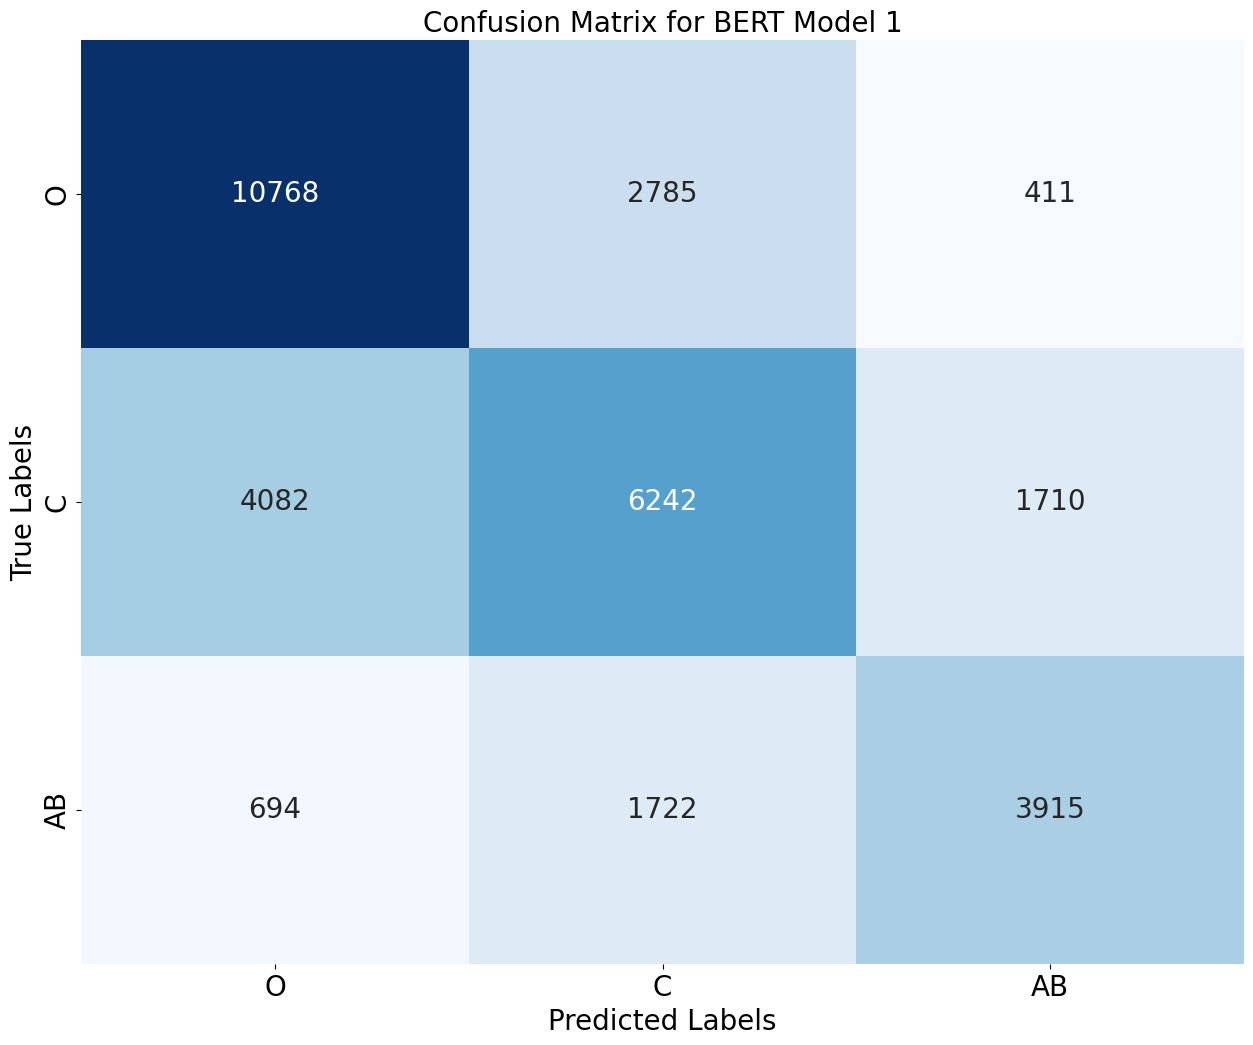

In [ ]:
# Get the indices of the top 2 BERT models based on accuracy
top_bert_indices = sorted(range(len(all_metrics_bert)), key=lambda i: all_metrics_bert[i]['accuracy'], reverse=True)[:1]

# Function to create a confusion matrix for a given model and true labels
def create_confusion_matrix(y_true, y_probs, class_names):
    y_pred = np.argmax(y_probs, axis=1)  # Get the predicted classes
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    return df_cm

    # Function to create a pretty confusion matrix plot with bigger font size
def plot_confusion_matrix(confusion_matrix, class_names, model_name):
    plt.figure(figsize=(15, 12))
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 20})
    ax.set_xlabel('Predicted Labels', fontsize=20)
    ax.set_ylabel('True Labels', fontsize=20)
    ax.set_xticklabels(class_names, fontsize=20)
    ax.set_yticklabels(class_names, fontsize=20)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=20)
    plt.show()


# Create confusion matrices for the top BERT models
for idx in top_bert_indices:
    model_name = f"BERT Model {idx+1}"
    print(f"\nConfusion Matrix for {model_name} (Batch Size: {bert_configurations[idx][0]}, Loss: {'BCE' if isinstance(bert_configurations[idx][1], tf.keras.losses.BinaryCrossentropy) else 'CCE'}):")
    df_cm = create_confusion_matrix(np.argmax(y_true_list[idx], axis=1), y_probs_list[idx], class_names)
    plot_confusion_matrix(df_cm, class_names, model_name)

In [ ]:
df_metrics_bert.to_csv('/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/bert_metrics.csv', index=False)

# RoBERTa

### Prep

#### Preprocess

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the datasets
df = pd.read_csv('/content/drive/MyDrive/Subasish/CN_NLP/CN_Hydro_Train.csv', encoding='latin1')
df = df.sample(frac=0.6, random_state=45)
df_pred = pd.read_csv('/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/Hydro_Inf.csv', encoding='ISO-8859-1')

# Split the train set into train and validation sets
train, valid = train_test_split(df, test_size=0.25, shuffle=True, random_state=42)

# Use df_pred as the test set
test = df_pred.copy()

# Extract features and labels for train set
x_train = train[["clean_Narrative"]]
y_train = train[["CRASH_SEVERITY_CD"]]

# Extract features and labels for validation set
x_valid = valid[["clean_Narrative"]]
y_valid = valid[["CRASH_SEVERITY_CD"]]

# Extract features and labels for test set
x_test = test[["clean_Narrative"]]
y_test = test[["CRASH_SEVERITY_CD"]]

# Display the shapes of the sets
print("Train set shape:", train.shape)
print("Validation set shape:", valid.shape)
print("Test set shape:", test.shape)


Train set shape: (96985, 53)
Validation set shape: (32329, 53)
Test set shape: (1950, 152)


In [ ]:
'''
seqlen = x_train["clean_Narrative"].apply(lambda x: len(x.split()))

sns.set_style("darkgrid")
plt.figure(figsize=(8,5))
sns.distplot(seqlen)
'''

'\nseqlen = x_train["clean_Narrative"].apply(lambda x: len(x.split()))\n\nsns.set_style("darkgrid")\nplt.figure(figsize=(8,5))\nsns.distplot(seqlen)\n'

In [ ]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
          '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
          '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
          '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
          '∙', ')', '↓', '、', '│', '(', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]


def preprocess_text(text):
    def clean_text(x):
        x = str(x)
        for punct in puncts:
            if punct in x:
                x = x.replace(punct, f' {punct} ')
        return x

    def clean_numbers(x):
        if bool(re.search(r'\d', x)):
            x = re.sub('[0-9]{5,}', '#####', x)
            x = re.sub('[0-9]{4}', '####', x)
            x = re.sub('[0-9]{3}', '###', x)
            x = re.sub('[0-9]{2}', '##', x)
        return x

    #text = text.lower()
    text = clean_text(text)
    text = clean_numbers(text)

    return text

In [ ]:
def preprocess(df, text_col_name):

    # lower and clean text
    df[text_col_name] = df[text_col_name].apply(lambda x: preprocess_text(x))

    # fill up the missing values
    df[text_col_name] = df[text_col_name].fillna("_##_")

    return df

In [ ]:

x_train = preprocess(x_train.copy(), "clean_Narrative")
x_valid = preprocess(x_valid.copy(), "clean_Narrative")

print(x_train.head())

                                          clean_Narrative
176375  unit1 traveling traveled left side roadway str...
94983   unit1 traveling roosevelt jackson  .  rear dri...
13938   unit1 traveling elm unit2 motor vehicle parked...
161436  unit1 traveling westwood northern bv high rate...
141081  unit1 traveling  ,  defiance williams county l...


#### Set up Model

In [ ]:
from transformers import RobertaTokenizer, TFAutoModel, AdamWeightDecay

import tensorflow as tf
SEQ_LEN = 175

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer
from joblib import Parallel, delayed




# Function to tokenize a batch of texts
def tokenize_batch(texts):
    tokens = tokenizer(texts, max_length=SEQ_LEN,
                       truncation=True, padding='max_length',
                       add_special_tokens=True, return_attention_mask=True,
                       return_token_type_ids=False, return_tensors='tf')
    return tokens["input_ids"], tokens["attention_mask"]

# Function to tokenize a single text (deprecated)
def tokenize_text(text):
    return tokenize_batch([text])

# Function to tokenize a DataFrame
def tokenize_dataframe(df):
    texts = df["clean_Narrative"].tolist()

    # Tokenize in batches
    results = Parallel(n_jobs=-1)(delayed(tokenize_batch)(texts[i:i+batch_size]) for i in range(0, len(texts), batch_size))

    input_ids, attention_masks = zip(*results)
    return (tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0))

# Example usage
batch_size = 32 # Adjust batch size as needed
train_input_ids, train_attention_masks = tokenize_dataframe(x_train)
valid_input_ids, valid_attention_masks = tokenize_dataframe(x_valid)

print(train_input_ids[0])

tf.Tensor(
[    0 19304   134  5796  8468   314   526 16719  5690  8146  4204   618
  1437   479  1437     2     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1    

In [ ]:
def one_encode_labels(df):
    topic_values = ["O", "C", "AB"]
    labels = []
    for index, row in df.iterrows():
        topic = row["CRASH_SEVERITY_CD"]
        if topic in topic_values:
            label = np.zeros((len(topic_values)))
            label[topic_values.index(topic)] = 1
            labels.append(label)
        else:
            # Handle invalid or missing sentiment values (e.g., log the error or skip the data point)
            print(f"Invalid sentiment value '{topic}' at index {index}. Skipping this data point.")
            # Alternatively, you can raise an exception if you want to halt the process.
            # raise ValueError(f"Invalid sentiment value '{sentiment}' at index {index}.")
    labels = np.asarray(labels)
    return labels

In [ ]:
print("Unique values in y_train sentiment column:", y_train['CRASH_SEVERITY_CD'].unique())
print("Unique values in y_valid sentiment column:", y_valid['CRASH_SEVERITY_CD'].unique())



Unique values in y_train sentiment column: ['O' 'AB' 'C']
Unique values in y_valid sentiment column: ['AB' 'C' 'O']


In [ ]:
y_train['CRASH_SEVERITY_CD']

176375     O
94983      O
13938     AB
161436    AB
141081     O
          ..
1080       O
3013       O
101204     C
207760     O
62869      O
Name: CRASH_SEVERITY_CD, Length: 96985, dtype: object

In [ ]:
# Map sentiment labels to integer values (assuming 'negative': 0, 'neutral': 1, 'positive': 2)
sentiment_mapping = {'O': 0, 'C': 1, 'AB': 2 }

# Convert the labels to integers using the mapping
y_train['CRASH_SEVERITY_CD'] = y_train['CRASH_SEVERITY_CD'].apply(lambda label: sentiment_mapping[label])
y_valid['CRASH_SEVERITY_CD'] = y_valid['CRASH_SEVERITY_CD'].apply(lambda label: sentiment_mapping[label])

# One-hot encode the integer labels
y_train_one_hot = tf.keras.utils.to_categorical(y_train['CRASH_SEVERITY_CD'], num_classes=3)
y_valid_one_hot = tf.keras.utils.to_categorical(y_valid['CRASH_SEVERITY_CD'], num_classes=3)



<ipython-input-16-66cf2948f251>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['CRASH_SEVERITY_CD'] = y_train['CRASH_SEVERITY_CD'].apply(lambda label: sentiment_mapping[label])
<ipython-input-16-66cf2948f251>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_valid['CRASH_SEVERITY_CD'] = y_valid['CRASH_SEVERITY_CD'].apply(lambda label: sentiment_mapping[label])


In [ ]:
y_train_one_hot.shape

(96985, 3)

In [ ]:
y_valid_one_hot.shape

(32329, 3)

In [ ]:
roberta = TFAutoModel.from_pretrained("roberta-base")

input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

embeddings = roberta(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.LSTM(128)(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(768)(X)
X = tf.keras.layers.Activation("relu")(X)
X = tf.keras.layers.Dense(768)(X)
X = tf.keras.layers.Dropout(0.1)(X)
y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(X)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
# Fine-tune BERT layers
for layer in model.layers:
    layer.trainable = True
model.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 175)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 175)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_ids[0][0]',           
 aModel)                     ngAndCrossAttentions(last_   32         'attention_mask[0][0]']      
                             hidden_state=(None, 175, 7                                       

## Model Containers

In [ ]:
from transformers import RobertaTokenizer, TFAutoModel, AdamWeightDecay
import tensorflow as tf
from tensorflow.keras.layers import Input
import itertools
import tensorflow as tf
from transformers import TFBertModel
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
import itertools

# Lists to store RoBERTa histories and other information
roberta_models = []
roberta_histories = []
roberta_configurations = []
y_true_list_roberta = []
y_probs_list_roberta = []

## Model 1: BS - 64, Loss - BCE

In [ ]:
import itertools
import tensorflow as tf
from transformers import TFBertModel
from tensorflow.keras.layers import Input
from transformers.optimization_tf import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the learning rate schedule function
def lr_schedule(epoch):
    initial_lr = 2e-05  # Initial learning rate
    decay = 0.95  # Decay rate
    if epoch < 5:
        return initial_lr
    else:
        return initial_lr * (decay ** (epoch - 5))

# Define the different combinations of batch size and loss function
batch_sizes = [64]
loss_functions = [tf.keras.losses.BinaryCrossentropy()]
#loss_functions = [tf.keras.losses.CategoricalCrossentropy()]

# Enable mixed precision training
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Enable XLA
tf.config.optimizer.set_jit(True)

# Create a single loop that iterates over all combinations of batch sizes and loss functions
combinations = list(itertools.product(batch_sizes, loss_functions))
for batch_size, loss_function in combinations:
    roberta = TFAutoModel.from_pretrained("roberta-base")
    input_ids = Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
    mask = Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

    embeddings = roberta(input_ids, attention_mask=mask)[0]

    #optimizer = SGD(learning_rate=1e-04, momentum=0.9)
    optimizer = Adam(2e-05, beta_1=0.8, beta_2=0.9)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)  # Enable mixed precision training
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

    # Use tf.data.Dataset to create efficient data pipelines
    train_dataset = tf.data.Dataset.from_tensor_slices(((train_input_ids, train_attention_masks), y_train_one_hot))
    train_dataset = train_dataset.batch(batch_size)

    valid_dataset = tf.data.Dataset.from_tensor_slices(((valid_input_ids, valid_attention_masks), y_valid_one_hot))
    valid_dataset = valid_dataset.batch(batch_size)

    # Define the learning rate scheduler
    lr_scheduler = LearningRateScheduler(lr_schedule)

    # Train the model using vectorized data pipeline
    history = model.fit(train_dataset, validation_data=valid_dataset, epochs=8, callbacks=[lr_scheduler])

    roberta_models.append(model)
    roberta_histories.append(history)

    # Save the configuration (batch size and loss function) used for this model
    roberta_configurations.append((batch_size, loss_function))

    # Get true labels for validation set
    y_true_roberta = y_valid_one_hot
    y_true_list_roberta.append(y_true_roberta)

    # Make predictions on validation set for this model using vectorized prediction
    y_probs_roberta = model.predict(valid_dataset)
    y_probs_list_roberta.append(y_probs_roberta)

Epoch 1/8


1516/1516 [==============================] - 322s 180ms/step - loss: 0.4879 - accuracy: 0.6023 - val_loss: 0.4862 - val_accuracy: 0.6066 - lr: 2.0000e-05
Epoch 2/8
1516/1516 [==============================] - 281s 185ms/step - loss: 0.4509 - accuracy: 0.6413 - val_loss: 0.4778 - val_accuracy: 0.6107 - lr: 2.0000e-05
Epoch 3/8
1516/1516 [==============================] - 261s 172ms/step - loss: 0.4320 - accuracy: 0.6584 - val_loss: 0.4757 - val_accuracy: 0.6192 - lr: 2.0000e-05
Epoch 4/8
1516/1516 [==============================] - 262s 173ms/step - loss: 0.4141 - accuracy: 0.6760 - val_loss: 0.4793 - val_accuracy: 0.6228 - lr: 2.0000e-05
Epoch 5/8
1516/1516 [==============================] - 262s 173ms/step - loss: 0.3959 - accuracy: 0.6922 - val_loss: 0.4880 - val_accuracy: 0.6345 - lr: 2.0000e-05
Epoch 6/8
1516/1516 [==============================] - 262s 173ms/step - loss: 0.3765 - accuracy: 0.7106 - val_loss: 0.5076 - val_accuracy: 0.6378 - lr: 2.0000e-05
Epoch 7/8
1516/1516 [=====

### Predictions

In [ ]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the tokenizer
#tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Maximum sequence length
max_sequence_length = 175

# Tokenize and encode the Story using the tokenizer
Story_list = df_pred['clean_Narrative'].astype(str).tolist()
encoded_texts = tokenizer.batch_encode_plus(Story_list, truncation=True, padding='max_length', max_length=max_sequence_length, return_tensors="tf")
input_ids = encoded_texts["input_ids"]
attention_mask = encoded_texts["attention_mask"]

# Choose a trained RoBERTa model from the roberta_models list
chosen_model_index = 0  # Choose the index of the desired model from roberta_models list
chosen_model = roberta_models[chosen_model_index]

# Predict using the chosen RoBERTa model
y_probs_roberta = chosen_model.predict((input_ids, attention_mask))

# Assuming y_probs_roberta has shape (num_samples, num_classes)
df_pred['RoBERTa_predictions'] = y_probs_roberta.argmax(axis=1)  # Store the predicted sentiment labels

# Convert prediction probabilities to a string representation and store in a column
df_pred['RoBERTa_predictions_probabilities'] = y_probs_roberta.tolist()


61/61 [==============================] - 9s 42ms/step


In [ ]:
sentiment_mapping = {'O': 0, 'C': 1, 'AB' : 2 }
# Print the mapping
print(sentiment_mapping)



# Convert the labels to integers using the mapping
df_pred['CRASH_SEVERITY_CD'] = df_pred['CRASH_SEVERITY_CD'].apply(lambda label: sentiment_mapping[label])


{'O': 0, 'C': 1, 'AB': 2}


In [ ]:
# Assuming you have the DataFrame 'df' with 'BERT_sent_Best' and 'CRASH_SEVERITY_CD' columns
# Define a mapping dictionary to convert numeric labels to class labels
#label_mapping = {0 : 'O', 1 : 'C', 2 : 'AB'}

# Apply the mapping to the 'BERT_predictions' column
#df_pred['RoBERTa_predictions'] = df_pred['RoBERTa_predictions'].map(label_mapping)
# Calculate the accuracy
correct_predictions = df_pred['RoBERTa_predictions'] == df_pred['CRASH_SEVERITY_CD']
accuracy = correct_predictions.mean() * 100

print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 64.46%


In [ ]:
df_pred.columns

Index(['Unnamed: 0', 'OBJECTID', 'Narrative', 'DOCUMENT_NBR', 'CRASH_YR',
       'CRASH_SEVERITY_CD', 'CRASH_MONTH_YEAR', 'DISTRICT_NBR', 'NLFID',
       'NLF_JUR_CD',
       ...
       'U3_SEQ_OF_EVENTS_6_CD', 'U3_SPECIAL_FUNCTION_CD',
       'U3_TRAFFIC_CONTROL_CD', 'U3_TYPE_OF_UNIT_CD', 'UNRESTRAIN_OCCUPANTS',
       'WEATHER_COND_CD', 'V1', 'clean_Narrative', 'RoBERTa_predictions',
       'RoBERTa_predictions_probabilities'],
      dtype='object', length=154)

In [ ]:
df_pred['RoBERTa_predictions'].value_counts()

0    1287
1     625
2      38
Name: RoBERTa_predictions, dtype: int64

In [ ]:
df_pred['CRASH_SEVERITY_CD'].value_counts()

0    1389
2     326
1     235
Name: CRASH_SEVERITY_CD, dtype: int64

In [ ]:

# Save the DataFrame to an Excel file
df_pred.to_csv('/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/Crash_predictions_Roberta.csv', index=False)

#### LIME

In [ ]:
import pandas as pd
import numpy as np
from lime.lime_text import LimeTextExplainer

# Define class names and their corresponding integer indices
class_names = ["O", "C", "AB"]
class_indices = {class_name: index for index, class_name in enumerate(class_names)}

Story_list = df_pred['clean_Narrative'].astype(str).tolist()

# Extract the predicted probabilities for each class
predicted_probabilities = df_pred['RoBERTa_predictions_probabilities']

# Choose a trained RoBERTa model from the roberta_models list
chosen_model_index = 0  # Choose the index of the desired model from roberta_models list
chosen_model = roberta_models[chosen_model_index]

# Create a LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

# Loop through each class in class_names
for class_name in class_names:
    # Find the top 10 predictions with the highest probability for the current class
    top_k_indices = np.argsort([probs[class_indices[class_name]] for probs in predicted_probabilities])[-10:]

    # Loop through the top 10 predictions and generate explanations
    for i, sample_index in enumerate(top_k_indices):
        # Replace 'O' with the current class name
        output_file_path = f'/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/LIME/RoBERTa_{class_name}_LIME_{i + 1}.html'

        # Define a custom predict function that takes text input and returns class probabilities
        def custom_predict(texts):
            # Tokenize and preprocess the texts (similar to your code above)
            encoded_texts = tokenizer.batch_encode_plus(texts, truncation=True, padding=True, return_tensors="tf")
            input_ids = encoded_texts["input_ids"]
            attention_mask = encoded_texts["attention_mask"]

            # Predict using the chosen RoBERTa model
            y_probs_roberta = chosen_model.predict((input_ids, attention_mask))

            return y_probs_roberta

        # Explain the prediction with the highest probability for the current class
        explanation = explainer.explain_instance(
            Story_list[sample_index],
            custom_predict,  # Pass the custom predict function
            labels=[class_indices[class_name]]
        )

        # Save each explanation to a separate HTML file
        explanation.save_to_file(output_file_path)

        # Display the explanations in the notebook
        print(f"Explanation for RoBERTa_{class_name}_LIME_{i + 1}:")
        # explanation.show_in_notebook(text=True)


157/157 [==============================] - 9s 14ms/step
Explanation for RoBERTa_O_LIME_1:
157/157 [==============================] - 5s 29ms/step
Explanation for RoBERTa_O_LIME_2:
157/157 [==============================] - 5s 28ms/step
Explanation for RoBERTa_O_LIME_3:
157/157 [==============================] - 6s 35ms/step
Explanation for RoBERTa_O_LIME_4:
157/157 [==============================] - 4s 27ms/step
Explanation for RoBERTa_O_LIME_5:
157/157 [==============================] - 5s 31ms/step
Explanation for RoBERTa_O_LIME_6:
157/157 [==============================] - 5s 31ms/step
Explanation for RoBERTa_O_LIME_7:
157/157 [==============================] - 5s 31ms/step
Explanation for RoBERTa_O_LIME_8:
157/157 [==============================] - 2s 10ms/step
Explanation for RoBERTa_O_LIME_9:
157/157 [==============================] - 5s 32ms/step
Explanation for RoBERTa_O_LIME_10:
157/157 [==============================] - 6s 40ms/step
Explanation for RoBERTa_C_LIME_1:
157/157 [

In [ ]:
df_pred.columns

Index(['Unnamed: 0', 'OBJECTID', 'Narrative', 'DOCUMENT_NBR', 'CRASH_YR',
       'CRASH_SEVERITY_CD', 'CRASH_MONTH_YEAR', 'DISTRICT_NBR', 'NLFID',
       'NLF_JUR_CD',
       ...
       'U3_SEQ_OF_EVENTS_6_CD', 'U3_SPECIAL_FUNCTION_CD',
       'U3_TRAFFIC_CONTROL_CD', 'U3_TYPE_OF_UNIT_CD', 'UNRESTRAIN_OCCUPANTS',
       'WEATHER_COND_CD', 'V1', 'clean_Narrative', 'RoBERTa_predictions',
       'RoBERTa_predictions_probabilities'],
      dtype='object', length=154)

In [ ]:
df_pred['RoBERTa_predictions'].value_counts()

0    1287
1     625
2      38
Name: RoBERTa_predictions, dtype: int64

## Plot ROC

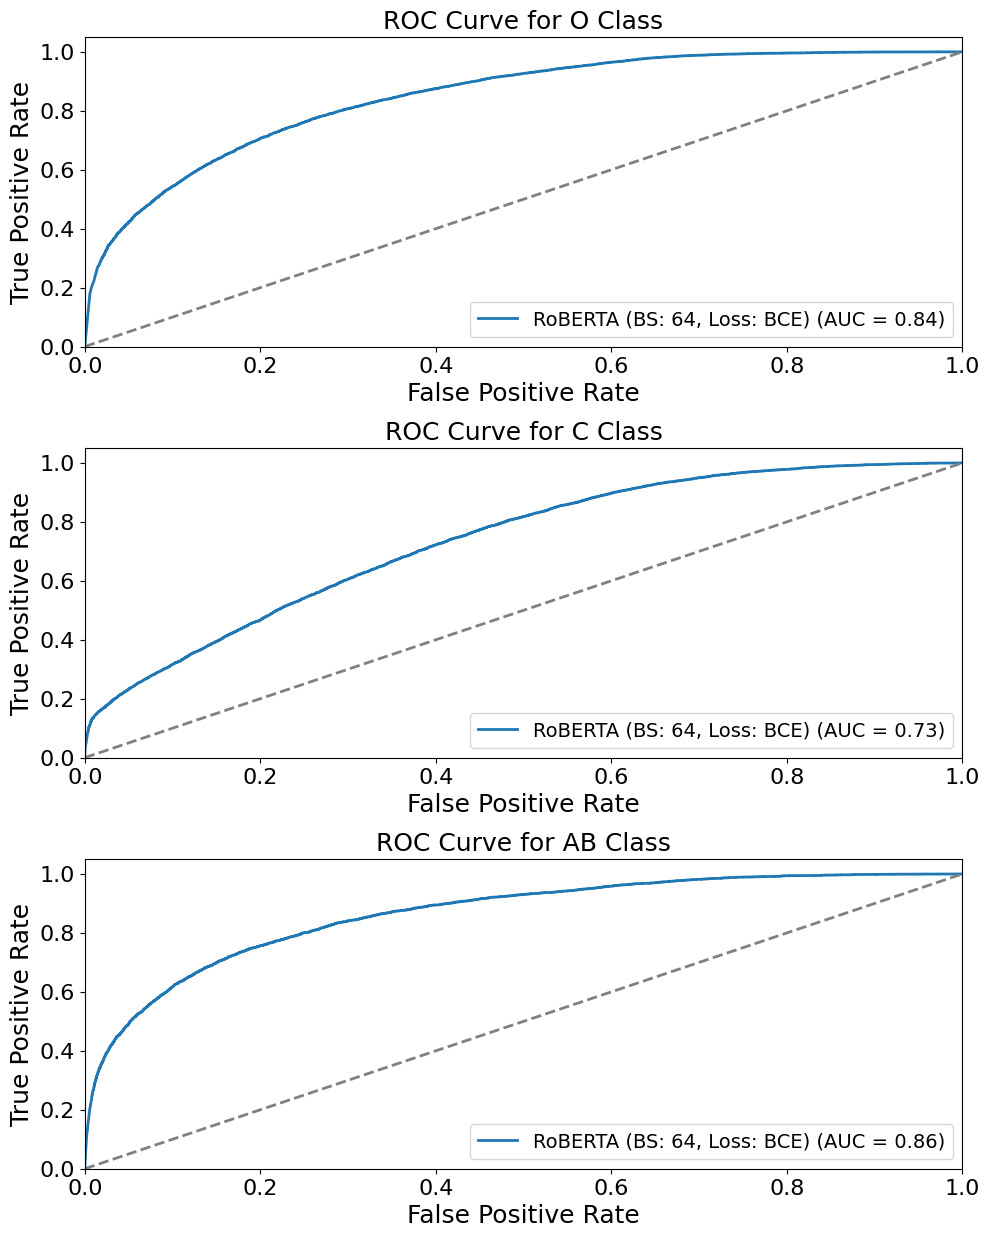

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to plot the ROC curves
def plot_roc_curve_per_class(y_true_list, y_probs_list, roberta_configurations, class_names):
    plt.figure(figsize=(10, 16))  # Adjust the figure size to accommodate vertically stacked subplots

    for i in range(3):  # Three classes: "negative", "neutral", "positive"
        plt.subplot(4, 1, i + 1)  # Change the subplot layout to stack them vertically

        for j in range(len(roberta_configurations)):  # Four models and their configurations
            y_true = y_true_list[j][:, i]
            y_probs = y_probs_list[j][:, i]
            fpr, tpr, _ = roc_curve(y_true, y_probs)
            roc_auc = auc(fpr, tpr)
            batch_size, loss_function = roberta_configurations[j]
            if isinstance(loss_function, tf.keras.losses.CategoricalCrossentropy):
                loss_function_name = 'CCE'
            elif isinstance(loss_function, tf.keras.losses.BinaryCrossentropy):
                loss_function_name = 'BCE'
            else:
                loss_function_name = str(loss_function)
            legend_label = f'RoBERTA (BS: {batch_size}, Loss: {loss_function_name}) (AUC = {roc_auc:.2f})'
            plt.plot(fpr, tpr, lw=2, label=legend_label)

        plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=18)  # Set font size for x-axis label
        plt.ylabel('True Positive Rate', fontsize=18)  # Set font size for y-axis label
        plt.xticks(fontsize=16)  # Set font size for x-axis tick labels
        plt.yticks(fontsize=16)  # Set font size for y-axis tick labels
        plt.title(f'ROC Curve for {class_names[i]} Class', fontsize=18)  # Set font size for plot title
        plt.legend(loc='lower right', fontsize=14)  # Set font size for legend

    plt.tight_layout()
    plt.show()

# Class names for the legend
class_names = ["O", "C", "AB"]

# Call the plot function with the correct arguments
plot_roc_curve_per_class(y_true_list_roberta, y_probs_list_roberta, roberta_configurations, class_names)


In [ ]:
from sklearn.metrics import classification_report

# Define class names for the three classes ('negative', 'neutral', 'positive')
class_names = ["O", "C", "AB"]

# Function to calculate metrics for each model
def calculate_metrics(y_true_list, y_probs_list):
    all_metrics = []
    for j in range(len(y_true_list)):
        y_pred = np.argmax(y_probs_list[j], axis=1)  # Get the predicted classes
        y_true = np.argmax(y_true_list[j], axis=1)  # Get the true classes
        metrics = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        all_metrics.append(metrics)
    return all_metrics

# Calculate metrics for RoBERTa models
all_metrics_roberta = calculate_metrics(y_true_list_roberta, y_probs_list_roberta)

# Function to create the metrics table as a DataFrame
def create_metrics_dataframe(all_metrics, all_configurations):
    metric_names = ['accuracy', 'macro avg']
    model_names = [f"Model {i+1}" for i in range(len(all_metrics))]
    rows = []

    for i in range(len(all_metrics)):
        model_name = f"Model {i+1}"
        bs = all_configurations[i][0]
        loss = "BCE" if isinstance(all_configurations[i][1], tf.keras.losses.BinaryCrossentropy) else "CCE"
        row = [model_name, bs, loss]

        for metric in metric_names:
            if isinstance(all_metrics[i][metric], float):
                # Handle the case when the metric is a float (e.g., accuracy)
                row.append(all_metrics[i][metric])
            else:
                # Handle the case when the metric is a dictionary (e.g., macro avg)
                for key, value in all_metrics[i][metric].items():
                    if key != 'support':
                        row.append(value)

        rows.append(row)

    columns = ['Model', 'BS', 'Loss Fn', 'Avg Accuracy', 'Avg Precision', 'Avg Recall', 'Avg F1-score']
    df = pd.DataFrame(rows, columns=columns)
    return df

# Create the metrics DataFrame for RoBERTa models
df_metrics_roberta = create_metrics_dataframe(all_metrics_roberta, roberta_configurations)

# Display the metrics table for RoBERTa models
print("\nRoBERTa Metrics:")
print(df_metrics_roberta)


RoBERTa Metrics:
     Model  BS Loss Fn  Avg Accuracy  Avg Precision  Avg Recall  Avg F1-score
0  Model 1  64     BCE      0.634848       0.629739    0.628686      0.628516



Confusion Matrix for RoBERTa Model 1 (Batch Size: 64, Loss: BCE):


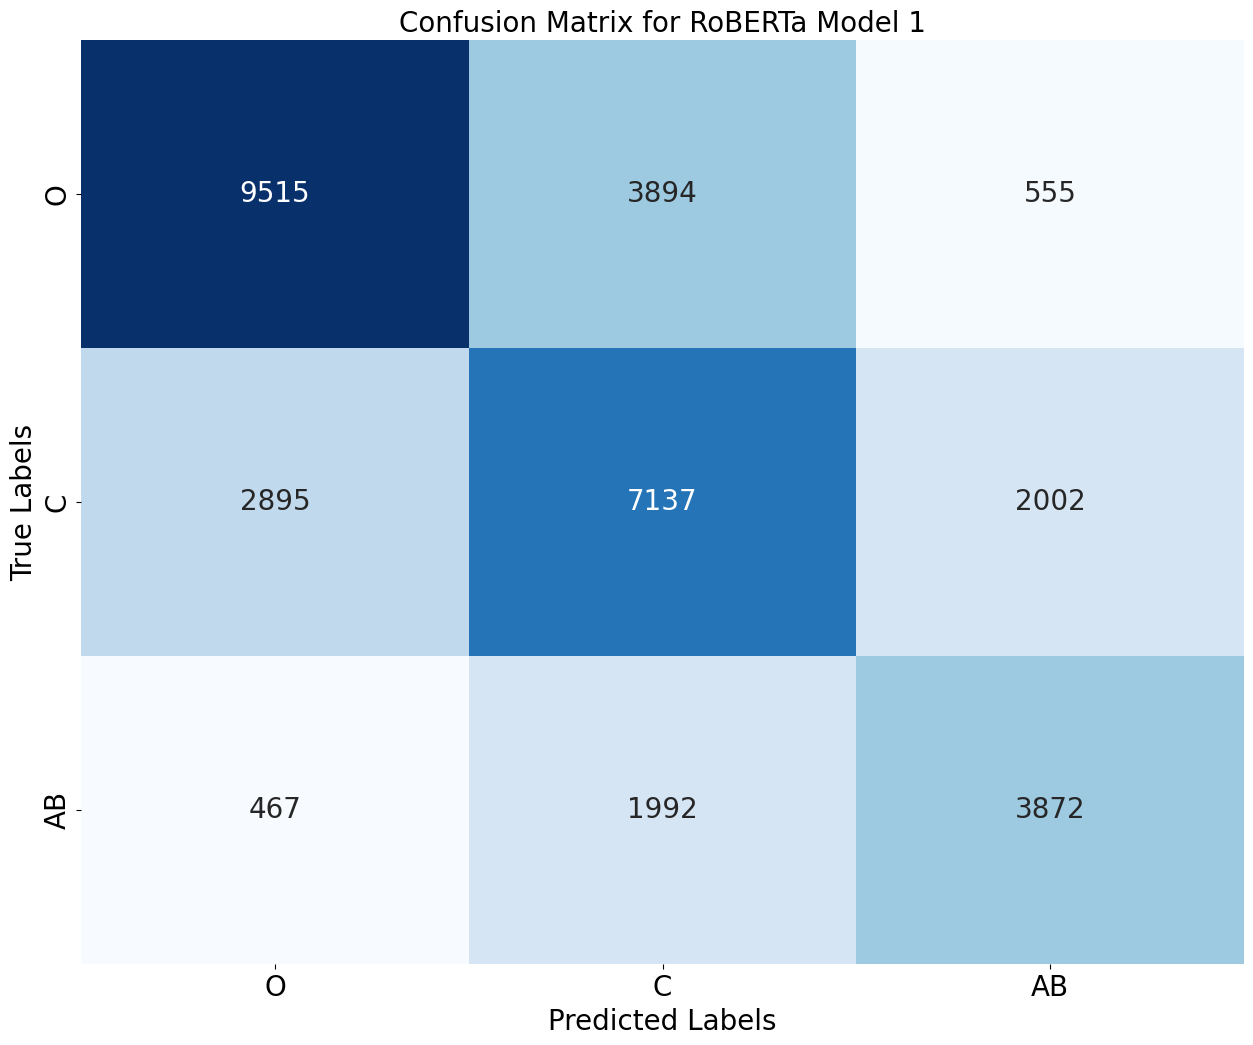

In [ ]:
# Get the indices of the top 2 RoBERTa models based on accuracy
top_roberta_indices = sorted(range(len(all_metrics_roberta)), key=lambda i: all_metrics_roberta[i]['accuracy'], reverse=True)[:1]


# Function to create a confusion matrix for a given model and true labels
def create_confusion_matrix(y_true, y_probs, class_names):
    y_pred = np.argmax(y_probs, axis=1)  # Get the predicted classes
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    return df_cm

# Function to create a pretty confusion matrix plot with bigger font size
def plot_confusion_matrix(confusion_matrix, class_names, model_name):
    plt.figure(figsize=(15, 12))
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 20})
    ax.set_xlabel('Predicted Labels', fontsize=20)
    ax.set_ylabel('True Labels', fontsize=20)
    ax.set_xticklabels(class_names, fontsize=20)
    ax.set_yticklabels(class_names, fontsize=20)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=20)
    plt.show()

# Create confusion matrices for the top RoBERTa models
for idx in top_roberta_indices:
    model_name = f"RoBERTa Model {idx+1}"
    print(f"\nConfusion Matrix for {model_name} (Batch Size: {roberta_configurations[idx][0]}, Loss: {'BCE' if isinstance(roberta_configurations[idx][1], tf.keras.losses.BinaryCrossentropy) else 'CCE'}):")
    df_cm = create_confusion_matrix(np.argmax(y_true_list_roberta[idx], axis=1), y_probs_list_roberta[idx], class_names)
    plot_confusion_matrix(df_cm, class_names, model_name)

In [ ]:
df_metrics_roberta.to_csv('/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/roberta_metrics.csv', index=False)

# DistilBERT

https://www.kaggle.com/code/akabaev/baseline-tf-distilbert

## Prep

In [ ]:
import pandas as pd
import numpy as np
import re
import itertools
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.layers import Input, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the datasets
df = pd.read_csv('/content/drive/MyDrive/Subasish/CN_NLP/CN_Hydro_Train.csv', encoding='latin1')
df = df.sample(frac=0.6, random_state=45)
df_pred = pd.read_csv('/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/Hydro_Inf.csv', encoding='ISO-8859-1')

# Split the train set into train and validation sets
train, valid = train_test_split(df, test_size=0.25, shuffle=True, random_state=42)

# Use df_pred as the test set
test = df_pred.copy()

# Extract features and labels for train set
x_train = train[["clean_Narrative"]]
y_train = train[["CRASH_SEVERITY_CD"]]

# Extract features and labels for validation set
x_valid = valid[["clean_Narrative"]]
y_valid = valid[["CRASH_SEVERITY_CD"]]

# Extract features and labels for test set
x_test = test[["clean_Narrative"]]
y_test = test[["CRASH_SEVERITY_CD"]]

# Display the shapes of the sets
print("Train set shape:", train.shape)
print("Validation set shape:", valid.shape)
print("Test set shape:", test.shape)


Train set shape: (96985, 53)
Validation set shape: (32329, 53)
Test set shape: (1950, 152)


In [ ]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
          '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
          '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
          '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
          '∙', ')', '↓', '、', '│', '(', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]


def preprocess_text(text):
    def clean_text(x):
        x = str(x)
        for punct in puncts:
            if punct in x:
                x = x.replace(punct, f' {punct} ')
        return x

    def clean_numbers(x):
        if bool(re.search(r'\d', x)):
            x = re.sub('[0-9]{5,}', '#####', x)
            x = re.sub('[0-9]{4}', '####', x)
            x = re.sub('[0-9]{3}', '###', x)
            x = re.sub('[0-9]{2}', '##', x)
        return x

    #text = text.lower()
    text = clean_text(text)
    text = clean_numbers(text)

    return text

In [ ]:
def preprocess(df, text_col_name):

    # lower and clean text
    df[text_col_name] = df[text_col_name].apply(lambda x: preprocess_text(x))

    # fill up the missing values
    df[text_col_name] = df[text_col_name].fillna("_##_")

    return df

In [ ]:

x_train = preprocess(x_train.copy(), "clean_Narrative")
x_valid = preprocess(x_valid.copy(), "clean_Narrative")

print(x_train.head())

                                          clean_Narrative
176375  unit1 traveling traveled left side roadway str...
94983   unit1 traveling roosevelt jackson  .  rear dri...
13938   unit1 traveling elm unit2 motor vehicle parked...
161436  unit1 traveling westwood northern bv high rate...
141081  unit1 traveling  ,  defiance williams county l...


In [ ]:
df = df.dropna(subset=["clean_Narrative"])

In [ ]:


SEQ_LEN = 175

# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Load the DistilBERT base model
distilbert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

# Model Architecture
input_ids = Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
mask = Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')
inputs = [input_ids, mask]

embeddings = distilbert_model(input_ids, attention_mask=mask)[0]

pooled_output = GlobalMaxPooling1D()(embeddings)

# Additional layers
dropout_rate = 0.1
dense_units = 768
X = Dropout(dropout_rate)(pooled_output)
X = Dense(dense_units, activation='relu')(X)
X = Dense(dense_units, activation='relu')(X)

# Output layer
output_units = 3
outputs = Dense(output_units, activation='softmax', name='outputs')(X)

model = Model(inputs=inputs, outputs=outputs)

# Fine-tune DistilBERT layers
for layer in distilbert_model.layers:
    layer.trainable = True

# Print model summary
model.summary()



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 175)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 175)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 stilBertModel)              den_state=(None, 175, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte                                     

In [ ]:

import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer
from joblib import Parallel, delayed


# Function to tokenize a batch of texts
def tokenize_batch(texts):
    tokens = tokenizer(texts, max_length=SEQ_LEN,
                       truncation=True, padding='max_length',
                       add_special_tokens=True, return_attention_mask=True,
                       return_token_type_ids=False, return_tensors='tf')
    return tokens["input_ids"], tokens["attention_mask"]

# Function to tokenize a single text (deprecated)
def tokenize_text(text):
    return tokenize_batch([text])

# Function to tokenize a DataFrame
def tokenize_dataframe(df):
    texts = df["clean_Narrative"].tolist()

    # Tokenize in batches
    results = Parallel(n_jobs=-1)(delayed(tokenize_batch)(texts[i:i+batch_size]) for i in range(0, len(texts), batch_size))

    input_ids, attention_masks = zip(*results)
    return (tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0))

# Example usage
batch_size = 32  # Adjust batch size as needed
train_input_ids, train_attention_masks = tokenize_dataframe(x_train)
valid_input_ids, valid_attention_masks = tokenize_dataframe(x_valid)

print(train_input_ids[0])




tf.Tensor(
[  101  3131  2487  7118  6158  2187  2217 18799  8478  8638  3384  2695
  1012   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

In [ ]:
# Map sentiment labels to integer values (assuming 'negative': 0, 'neutral': 1, 'positive': 2)
sentiment_mapping = {'O': 0, 'C': 1, 'AB': 2 }

# Convert the labels to integers using the mapping
y_train['CRASH_SEVERITY_CD'] = y_train['CRASH_SEVERITY_CD'].apply(lambda label: sentiment_mapping[label])
y_valid['CRASH_SEVERITY_CD'] = y_valid['CRASH_SEVERITY_CD'].apply(lambda label: sentiment_mapping[label])

# One-hot encode the integer labels
y_train_one_hot = tf.keras.utils.to_categorical(y_train['CRASH_SEVERITY_CD'], num_classes=3)
y_valid_one_hot = tf.keras.utils.to_categorical(y_valid['CRASH_SEVERITY_CD'], num_classes=3)



<ipython-input-45-66cf2948f251>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['CRASH_SEVERITY_CD'] = y_train['CRASH_SEVERITY_CD'].apply(lambda label: sentiment_mapping[label])
<ipython-input-45-66cf2948f251>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_valid['CRASH_SEVERITY_CD'] = y_valid['CRASH_SEVERITY_CD'].apply(lambda label: sentiment_mapping[label])


## Model containers

In [ ]:
import itertools
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

dist_models = []
dist_histories = []
dist_configurations = []  # To store the batch size and loss function for each model
dist_y_true_list = []
dist_y_probs_list = []

## Model 1: BS 64, Loss - BCE

In [ ]:


# Define the learning rate schedule function
def lr_schedule(epoch):
    initial_lr = 2e-05  # Initial learning rate
    decay = 0.95  # Decay rate
    if epoch < 5:
        return initial_lr
    else:
        return initial_lr * (decay ** (epoch - 5))

# Define the different combinations of batch size and loss function
batch_sizes = [64]
loss_functions = [tf.keras.losses.BinaryCrossentropy()]

# Enable mixed precision training
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Enable XLA
tf.config.optimizer.set_jit(True)

# Create a single loop that iterates over all combinations of batch sizes and loss functions
combinations = list(itertools.product(batch_sizes, loss_functions))
for batch_size, loss_function in combinations:
    distilbert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
    input_ids = Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
    mask = Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

    embeddings = distilbert_model(input_ids, attention_mask=mask)[0]

    optimizer = Adam(2e-05, beta_1=0.8, beta_2=0.9)

    # Compile the model with mixed precision optimizer
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

    # Use tf.data.Dataset to create efficient data pipelines
    train_dataset = tf.data.Dataset.from_tensor_slices(((train_input_ids, train_attention_masks), y_train_one_hot))
    train_dataset = train_dataset.batch(batch_size)

    valid_dataset = tf.data.Dataset.from_tensor_slices(((valid_input_ids, valid_attention_masks), y_valid_one_hot))
    valid_dataset = valid_dataset.batch(batch_size)

    # Define the learning rate scheduler
    lr_scheduler = LearningRateScheduler(lr_schedule)

    # Train the model using vectorized data pipeline and the learning rate scheduler
    history = model.fit(train_dataset, validation_data=valid_dataset, epochs=8, callbacks=[lr_scheduler])

    dist_models.append(model)
    dist_histories.append(history)

    # Save the configuration (batch size and loss function) used for this model
    dist_configurations.append((batch_size, loss_function))

    # Get true labels and predicted probabilities for validation set using vectorized prediction
    y_true = y_valid_one_hot
    y_probs = model.predict(valid_dataset)

    dist_y_true_list.append(y_true)
    dist_y_probs_list.append(y_probs)



Epoch 1/8
1516/1516 [==============================] - 182s 88ms/step - loss: 0.4914 - accuracy: 0.5986 - val_loss: 0.4615 - val_accuracy: 0.6281 - lr: 2.0000e-05
Epoch 2/8
1516/1516 [==============================] - 134s 89ms/step - loss: 0.4457 - accuracy: 0.6462 - val_loss: 0.4550 - val_accuracy: 0.6387 - lr: 2.0000e-05
Epoch 3/8
1516/1516 [==============================] - 93s 62ms/step - loss: 0.4204 - accuracy: 0.6695 - val_loss: 0.4576 - val_accuracy: 0.6413 - lr: 2.0000e-05
Epoch 4/8
1516/1516 [==============================] - 93s 61ms/step - loss: 0.3920 - accuracy: 0.6971 - val_loss: 0.4788 - val_accuracy: 0.6424 - lr: 2.0000e-05
Epoch 5/8
1516/1516 [==============================] - 93s 61ms/step - loss: 0.3611 - accuracy: 0.7259 - val_loss: 0.5044 - val_accuracy: 0.6449 - lr: 2.0000e-05
Epoch 6/8
1516/1516 [==============================] - 93s 61ms/step - loss: 0.3315 - accuracy: 0.7524 - val_loss: 0.5347 - val_accuracy: 0.6436 - lr: 2.0000e-05
Epoch 7/8
1516/1516 [=====

### Predictions

In [ ]:
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Maximum sequence length
max_sequence_length = 175

# Tokenize and encode the Story using the tokenizer
Story_list = df_pred['clean_Narrative'].astype(str).tolist()
encoded_texts = tokenizer.batch_encode_plus(Story_list, truncation=True, padding='max_length', max_length=max_sequence_length, return_tensors="tf")
input_ids = encoded_texts["input_ids"]
attention_mask = encoded_texts["attention_mask"]

# Choose a trained RoBERTa model from the roberta_models list
chosen_model_index = 0  # Choose the index of the desired model from roberta_models list
chosen_model = dist_models[chosen_model_index]

# Predict using the chosen RoBERTa model
dist_y_probs = chosen_model.predict((input_ids, attention_mask))

# Assuming y_probs_roberta has shape (num_samples, num_classes)
df_pred['distilBERT_predictions'] = dist_y_probs.argmax(axis=1)  # Store the predicted sentiment labels

# Convert prediction probabilities to a string representation and store in a column
df_pred['distilBERT_predictions_probabilities'] = dist_y_probs.tolist()


61/61 [==============================] - 15s 17ms/step


In [ ]:
sentiment_mapping = {'O': 0, 'C': 1, 'AB' : 2 }
# Print the mapping
print(sentiment_mapping)



# Convert the labels to integers using the mapping
df_pred['CRASH_SEVERITY_CD'] = df_pred['CRASH_SEVERITY_CD'].apply(lambda label: sentiment_mapping[label])


{'O': 0, 'C': 1, 'AB': 2}


#### LIME

In [ ]:
import pandas as pd
import numpy as np
from lime.lime_text import LimeTextExplainer

# Define class names and their corresponding integer indices
class_names = ["O", "C", "AB"]
class_indices = {class_name: index for index, class_name in enumerate(class_names)}

Story_list = df_pred['clean_Narrative'].astype(str).tolist()

# Extract the predicted probabilities for each class
predicted_probabilities = df_pred['distilBERT_predictions_probabilities']

# Choose a trained DistilBERT model from the dist_models list
chosen_model_index = 0  # Choose the index of the desired model from dist_models list
chosen_model = dist_models[chosen_model_index]

# Create a LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

# Loop through each class in class_names
for class_name in class_names:
    # Find the top 10 predictions with the highest probability for the current class
    top_k_indices = np.argsort([probs[class_indices[class_name]] for probs in predicted_probabilities])[-10:]

    # Loop through the top 10 predictions and generate explanations
    for i, sample_index in enumerate(top_k_indices):
        # Replace 'O' with the current class name
        output_file_path = f'/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/LIME/Dist_{class_name}_LIME_{i + 1}.html'

        # Define a custom predict function that takes text input and returns class probabilities
        def custom_predict(texts):
            # Tokenize and preprocess the texts (similar to your code above)
            encoded_texts = tokenizer.batch_encode_plus(texts, truncation=True, padding=True, return_tensors="tf")
            input_ids = encoded_texts["input_ids"]
            attention_mask = encoded_texts["attention_mask"]

            # Predict using the chosen DistilBERT model
            dist_y_probs = chosen_model.predict((input_ids, attention_mask))

            return dist_y_probs

        # Explain the prediction with the highest probability for the current class
        explanation = explainer.explain_instance(
            Story_list[sample_index],
            custom_predict,  # Pass the custom predict function
            labels=[class_indices[class_name]]
        )

        # Save each explanation to a separate HTML file
        explanation.save_to_file(output_file_path)

        # Display the explanations in the notebook
        print(f"Explanation for Dist_{class_name}_LIME_{i + 1}:")
        # explanation.show_in_notebook(text=True)


157/157 [==============================] - 11s 10ms/step
Explanation for Dist_O_LIME_1:
157/157 [==============================] - 8s 49ms/step
Explanation for Dist_O_LIME_2:
157/157 [==============================] - 9s 58ms/step
Explanation for Dist_O_LIME_3:
157/157 [==============================] - 9s 55ms/step
Explanation for Dist_O_LIME_4:
157/157 [==============================] - 11s 71ms/step
Explanation for Dist_O_LIME_5:
157/157 [==============================] - 9s 56ms/step
Explanation for Dist_O_LIME_6:
157/157 [==============================] - 9s 55ms/step
Explanation for Dist_O_LIME_7:
157/157 [==============================] - 9s 57ms/step
Explanation for Dist_O_LIME_8:
157/157 [==============================] - 9s 58ms/step
Explanation for Dist_O_LIME_9:
157/157 [==============================] - 9s 58ms/step
Explanation for Dist_O_LIME_10:
157/157 [==============================] - 9s 59ms/step
Explanation for Dist_C_LIME_1:
157/157 [==============================]

In [ ]:

# Calculate the accuracy
correct_predictions = df_pred['distilBERT_predictions'] == df_pred['CRASH_SEVERITY_CD']
accuracy = correct_predictions.mean() * 100

print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 71.95%


In [ ]:
df_pred['distilBERT_predictions'].value_counts()

0    1561
1     362
2      27
Name: distilBERT_predictions, dtype: int64

In [ ]:
df_pred['CRASH_SEVERITY_CD'].value_counts()

0    1389
2     326
1     235
Name: CRASH_SEVERITY_CD, dtype: int64

In [ ]:
df_pred.columns

Index(['Unnamed: 0', 'OBJECTID', 'Narrative', 'DOCUMENT_NBR', 'CRASH_YR',
       'CRASH_SEVERITY_CD', 'CRASH_MONTH_YEAR', 'DISTRICT_NBR', 'NLFID',
       'NLF_JUR_CD',
       ...
       'U3_SEQ_OF_EVENTS_6_CD', 'U3_SPECIAL_FUNCTION_CD',
       'U3_TRAFFIC_CONTROL_CD', 'U3_TYPE_OF_UNIT_CD', 'UNRESTRAIN_OCCUPANTS',
       'WEATHER_COND_CD', 'V1', 'clean_Narrative', 'distilBERT_predictions',
       'distilBERT_predictions_probabilities'],
      dtype='object', length=154)

In [ ]:
# Assuming you have the DataFrame 'df'

# Save the DataFrame to an Excel file
df_pred.to_csv('/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/Crash_predictions_Dist.csv', index=False)




In [ ]:

from sklearn.metrics import classification_report

# Define class names for the three classes ('negative', 'neutral', 'positive')
class_names = ["O", "C", "AB"]

# Function to calculate metrics for each model
def calculate_metrics(y_true_list, y_probs_list):
    all_metrics = []
    for j in range(len(y_true_list)):
        y_pred = np.argmax(y_probs_list[j], axis=1)  # Get the predicted classes
        y_true = np.argmax(y_true_list[j], axis=1)  # Get the true classes
        metrics = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        all_metrics.append(metrics)
    return all_metrics

# Calculate metrics for BERT models
#all_metrics_bert = calculate_metrics(y_true_list, y_probs_list)

# Calculate metrics for RoBERTa models
#all_metrics_roberta = calculate_metrics(y_true_list_roberta, y_probs_list_roberta)

all_metrics_dist = calculate_metrics(dist_y_true_list, dist_y_probs_list)

# Function to create the metrics table as a DataFrame
def create_metrics_dataframe(all_metrics, all_configurations):
    metric_names = ['accuracy', 'macro avg']
    model_names = [f"Model {i+1}" for i in range(len(all_metrics))]
    rows = []

    for i in range(len(all_metrics)):
        model_name = f"Model {i+1}"
        bs = all_configurations[i][0]
        loss = "BCE" if isinstance(all_configurations[i][1], tf.keras.losses.BinaryCrossentropy) else "CCE"
        row = [model_name, bs, loss]

        for metric in metric_names:
            if isinstance(all_metrics[i][metric], float):
                # Handle the case when the metric is a float (e.g., accuracy)
                row.append(all_metrics[i][metric])
            else:
                # Handle the case when the metric is a dictionary (e.g., macro avg)
                for key, value in all_metrics[i][metric].items():
                    if key != 'support':
                        row.append(value)

        rows.append(row)

    columns = ['Model', 'BS', 'Loss Fn', 'Avg Accuracy', 'Avg Precision', 'Avg Recall', 'Avg F1-score']
    df = pd.DataFrame(rows, columns=columns)
    return df

# Create the metrics DataFrame for BERT models
#df_metrics_bert = create_metrics_dataframe(all_metrics_bert, bert_configurations)

# Create the metrics DataFrame for RoBERTa models
#df_metrics_roberta = create_metrics_dataframe(all_metrics_roberta, roberta_configurations)

df_metrics_dist = create_metrics_dataframe(all_metrics_dist, dist_configurations)

# Display the metrics table for BERT models
print("BERT Metrics:")
#print(df_metrics_bert)

# Display the metrics table for RoBERTa models
print("\nRoBERTa Metrics:")
#print(df_metrics_roberta)

print("\nDist_BERT Metrics:")
print(df_metrics_dist)


BERT Metrics:

RoBERTa Metrics:

Dist_BERT Metrics:
     Model  BS Loss Fn  Avg Accuracy  Avg Precision  Avg Recall  Avg F1-score
0  Model 1  64     BCE      0.643323       0.638886    0.625636      0.627088


In [ ]:
df_pred['distilBERT_predictions'].value_counts()

0    1561
1     362
2      27
Name: distilBERT_predictions, dtype: int64

In [ ]:
df_pred.columns

Index(['Unnamed: 0', 'OBJECTID', 'Narrative', 'DOCUMENT_NBR', 'CRASH_YR',
       'CRASH_SEVERITY_CD', 'CRASH_MONTH_YEAR', 'DISTRICT_NBR', 'NLFID',
       'NLF_JUR_CD',
       ...
       'U3_SEQ_OF_EVENTS_6_CD', 'U3_SPECIAL_FUNCTION_CD',
       'U3_TRAFFIC_CONTROL_CD', 'U3_TYPE_OF_UNIT_CD', 'UNRESTRAIN_OCCUPANTS',
       'WEATHER_COND_CD', 'V1', 'clean_Narrative', 'distilBERT_predictions',
       'distilBERT_predictions_probabilities'],
      dtype='object', length=154)

## Plot ROC

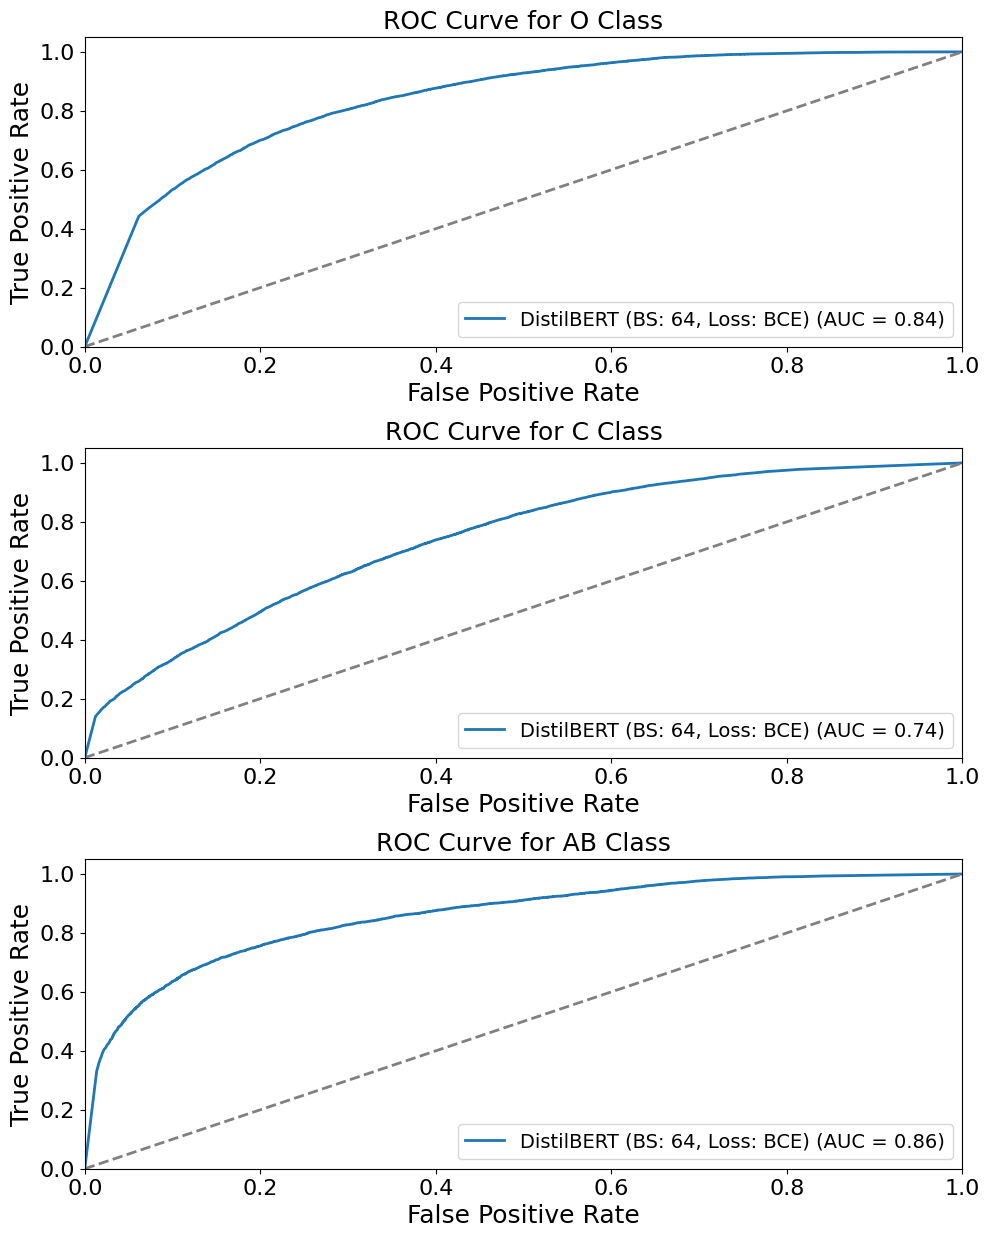

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to plot the ROC curves
def plot_roc_curve_per_class(y_true_list, y_probs_list, dist_configurations, class_names):
    plt.figure(figsize=(10, 16))  # Adjust the figure size to accommodate vertically stacked subplots

    for i in range(3):  # Three classes: "negative", "neutral", "positive"
        plt.subplot(4, 1, i + 1)  # Change the subplot layout to stack them vertically

        for j in range(len(dist_configurations)):  # Four models and their configurations
            y_true = y_true_list[j][:, i]
            y_probs = y_probs_list[j][:, i]
            fpr, tpr, _ = roc_curve(y_true, y_probs)
            roc_auc = auc(fpr, tpr)
            batch_size, loss_function = dist_configurations[j]
            if isinstance(loss_function, tf.keras.losses.CategoricalCrossentropy):
                loss_function_name = 'CCE'
            elif isinstance(loss_function, tf.keras.losses.BinaryCrossentropy):
                loss_function_name = 'BCE'
            else:
                loss_function_name = str(loss_function)
            legend_label = f'DistilBERT (BS: {batch_size}, Loss: {loss_function_name}) (AUC = {roc_auc:.2f})'
            plt.plot(fpr, tpr, lw=2, label=legend_label)

        plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=18)  # Set font size for x-axis label
        plt.ylabel('True Positive Rate', fontsize=18)  # Set font size for y-axis label
        plt.xticks(fontsize=16)  # Set font size for x-axis tick labels
        plt.yticks(fontsize=16)  # Set font size for y-axis tick labels
        plt.title(f'ROC Curve for {class_names[i]} Class', fontsize=18)  # Set font size for plot title
        plt.legend(loc='lower right', fontsize=14)  # Set font size for legend

    plt.tight_layout()
    plt.show()

# Class names for the legend
class_names = ["O", "C", "AB"]

# Call the plot function with the correct arguments
plot_roc_curve_per_class(dist_y_true_list, dist_y_probs_list, dist_configurations, class_names)


In [ ]:
from sklearn.metrics import classification_report

# Define class names for the three classes ('negative', 'neutral', 'positive')
class_names = ["O", "C", "AB"]

# Function to calculate metrics for each model
def calculate_metrics(y_true_list, y_probs_list):
    all_metrics = []
    for j in range(len(y_true_list)):
        y_pred = np.argmax(y_probs_list[j], axis=1)  # Get the predicted classes
        y_true = np.argmax(y_true_list[j], axis=1)  # Get the true classes
        metrics = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        all_metrics.append(metrics)
    return all_metrics

all_metrics_dist = calculate_metrics(dist_y_true_list, dist_y_probs_list)

# Function to create the metrics table as a DataFrame
def create_metrics_dataframe(all_metrics, all_configurations):
    metric_names = ['accuracy', 'macro avg']
    model_names = [f"Model {i+1}" for i in range(len(all_metrics))]
    rows = []

    for i in range(len(all_metrics)):
        model_name = f"Model {i+1}"
        bs = all_configurations[i][0]
        loss = "BCE" if isinstance(all_configurations[i][1], tf.keras.losses.BinaryCrossentropy) else "CCE"
        row = [model_name, bs, loss]

        for metric in metric_names:
            if isinstance(all_metrics[i][metric], float):
                # Handle the case when the metric is a float (e.g., accuracy)
                row.append(all_metrics[i][metric])
            else:
                # Handle the case when the metric is a dictionary (e.g., macro avg)
                for key, value in all_metrics[i][metric].items():
                    if key != 'support':
                        row.append(value)

        rows.append(row)

    columns = ['Model', 'BS', 'Loss Fn', 'Avg Accuracy', 'Avg Precision', 'Avg Recall', 'Avg F1-score']
    df = pd.DataFrame(rows, columns=columns)
    return df

df_metrics_dist = create_metrics_dataframe(all_metrics_dist, dist_configurations)

print("\nDist_BERT Metrics:")
print(df_metrics_dist)


Dist_BERT Metrics:
     Model  BS Loss Fn  Avg Accuracy  Avg Precision  Avg Recall  Avg F1-score
0  Model 1  64     BCE      0.643323       0.638886    0.625636      0.627088



Confusion Matrix for DistBERT Model 1 (Batch Size: 64, Loss: BCE):


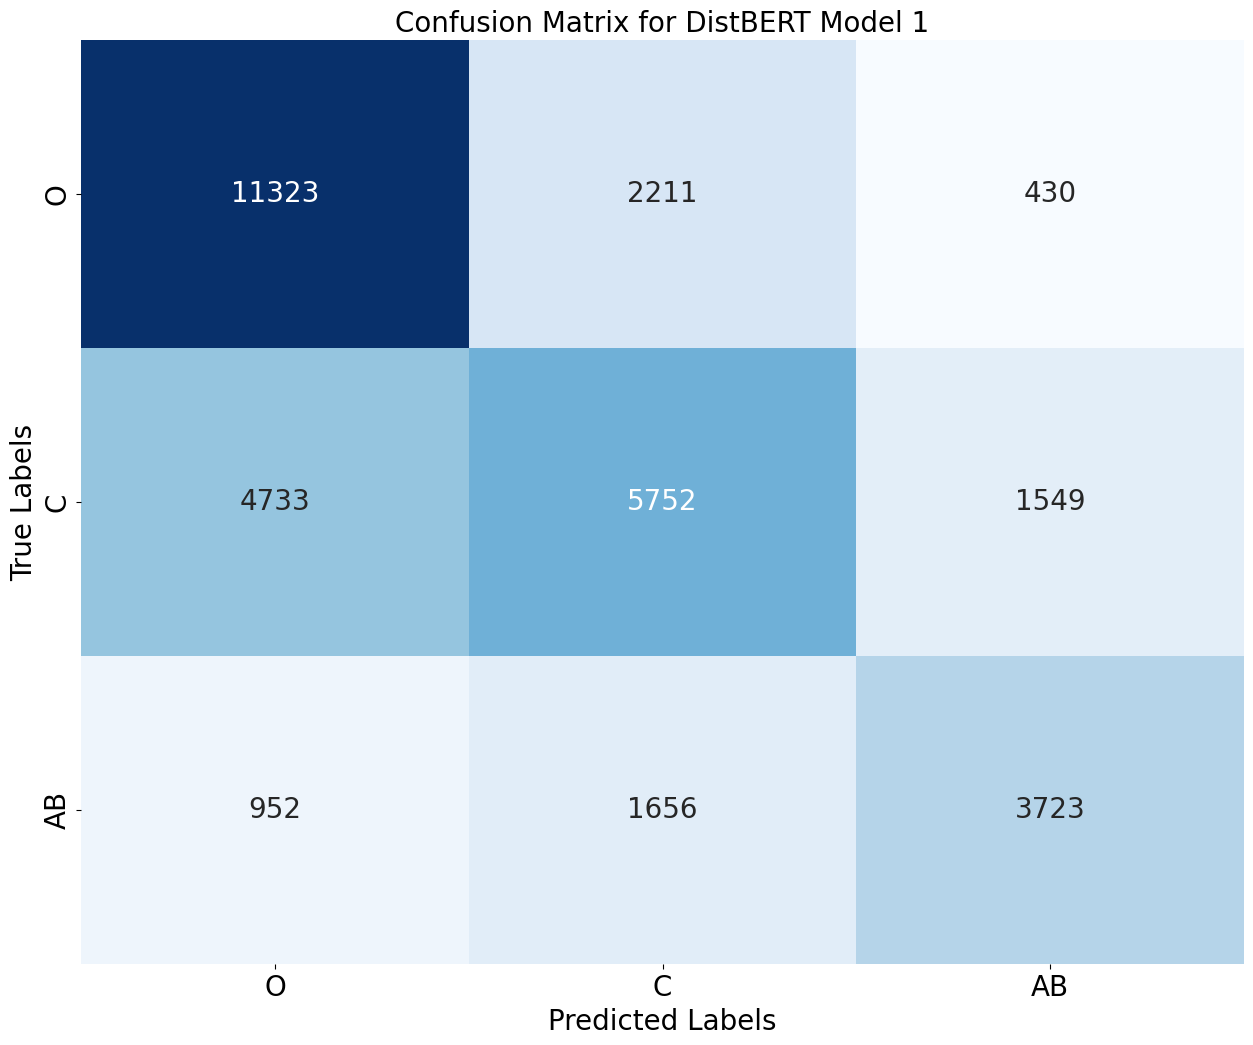

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the indices of the top 2 dist models based on accuracy
top_dist_indices = sorted(range(len(all_metrics_dist)), key=lambda i: all_metrics_dist[i]['accuracy'], reverse=True)[:1]

# Function to create a confusion matrix for a given model and true labels
def create_confusion_matrix(y_true, y_probs, class_names):
    y_pred = np.argmax(y_probs, axis=1)  # Get the predicted classes
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    return df_cm

# Function to create a pretty confusion matrix plot with bigger font size
def plot_confusion_matrix(confusion_matrix, class_names, model_name):
    plt.figure(figsize=(15, 12))
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 20})
    ax.set_xlabel('Predicted Labels', fontsize=20)
    ax.set_ylabel('True Labels', fontsize=20)
    ax.set_xticklabels(class_names, fontsize=20)
    ax.set_yticklabels(class_names, fontsize=20)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=20)
    plt.show()


# Create confusion matrices for the top DistBERT models
for idx in top_dist_indices:
    model_name = f"DistBERT Model {idx+1}"
    print(f"\nConfusion Matrix for {model_name} (Batch Size: {dist_configurations[idx][0]}, Loss: {'BCE' if isinstance(dist_configurations[idx][1], tf.keras.losses.BinaryCrossentropy) else 'CCE'}):")
    df_cm = create_confusion_matrix(np.argmax(dist_y_true_list[idx], axis=1), dist_y_probs_list[idx], class_names)
    plot_confusion_matrix(df_cm, class_names, model_name)


In [ ]:
df_metrics_dist.to_csv('/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/distBERT_metrics.csv')

# Metrics and Figures

## Formatting

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the datasets
df = pd.read_csv('/content/drive/MyDrive/Subasish/CN_NLP/CN_Hydro_Train.csv', encoding='latin1')
df = df.sample(frac=0.6, random_state=45)
df_pred = pd.read_csv('/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/Hydro_Inf.csv', encoding='ISO-8859-1')

# Split the train set into train and validation sets
train, valid = train_test_split(df, test_size=0.25, shuffle=True, random_state=42)

# Use df_pred as the test set
test = df_pred.copy()

# Extract features and labels for train set
x_train = train[["clean_Narrative"]]
y_train = train[["CRASH_SEVERITY_CD"]]

# Extract features and labels for validation set
x_valid = valid[["clean_Narrative"]]
y_valid = valid[["CRASH_SEVERITY_CD"]]

# Extract features and labels for test set
x_test = test[["clean_Narrative"]]
y_test = test[["CRASH_SEVERITY_CD"]]

# Display the shapes of the sets
print("Train set shape:", train.shape)
print("Validation set shape:", valid.shape)
print("Test set shape:", test.shape)


Train set shape: (96985, 53)
Validation set shape: (32329, 53)
Test set shape: (1950, 152)


In [ ]:
y_train.value_counts()

CRASH_SEVERITY_CD
O                    41304
C                    36597
AB                   19084
dtype: int64

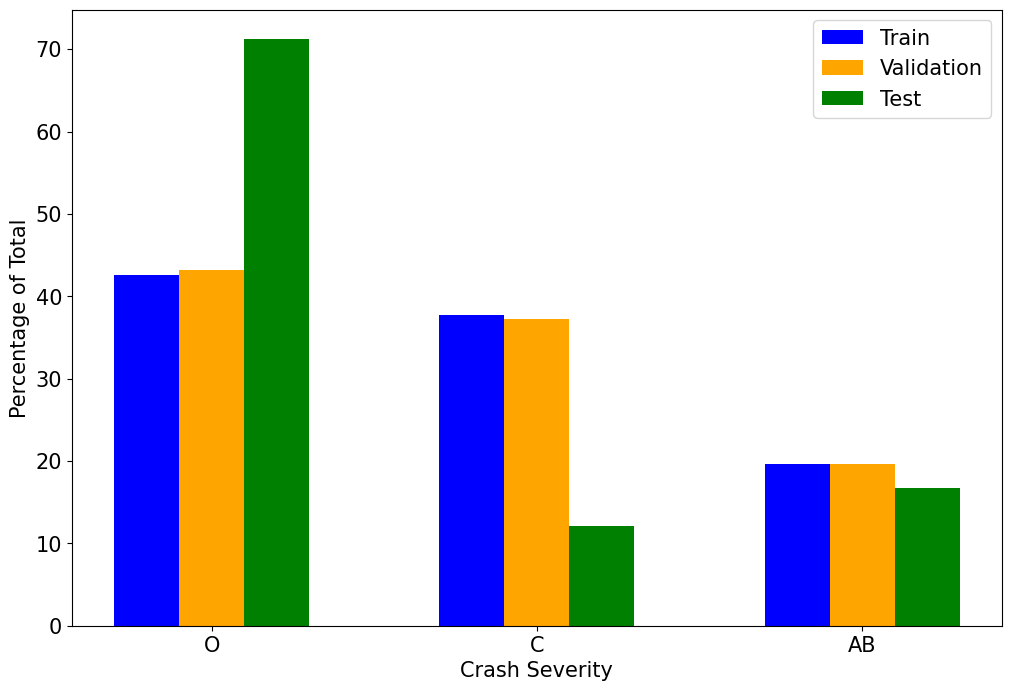

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot class frequency bar chart with percentages
def plot_class_frequency(train, valid, test, class_labels):
    class_labels = [str(label) for label in class_labels]  # Convert labels to strings

    train_counts = train['CRASH_SEVERITY_CD'].value_counts().reindex(class_labels, fill_value=0)
    valid_counts = valid['CRASH_SEVERITY_CD'].value_counts().reindex(class_labels, fill_value=0)
    test_counts = test['CRASH_SEVERITY_CD'].value_counts().reindex(class_labels, fill_value=0)

    # Calculate percentages
    total_train = train_counts.sum()
    total_valid = valid_counts.sum()
    total_test = test_counts.sum()

    train_percentages = (train_counts / total_train) * 100
    valid_percentages = (valid_counts / total_valid) * 100
    test_percentages = (test_counts / total_test) * 100

    # Plot bar chart
    fig, ax = plt.subplots(figsize=(12, 8))
    bar_width = 0.2
    index = np.arange(len(class_labels))

    train_bar = ax.bar(index, train_percentages, width=bar_width, label='Train', color='blue')
    valid_bar = ax.bar(index + bar_width, valid_percentages, width=bar_width, label='Validation', color='orange')
    test_bar = ax.bar(index + 2*bar_width, test_percentages, width=bar_width, label='Test', color='green')

    ax.set_xlabel('Crash Severity', fontsize=15)
    ax.set_ylabel('Percentage of Total', fontsize=15)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(class_labels, fontsize=15)
    ax.legend(fontsize=15)
    # Increase font size of y-axis ticks
    ax.tick_params(axis='y', labelsize=15)

    plt.show()

# Define class labels
class_labels = ['O', 'C', 'AB']

# Plot class frequency bar chart with percentages
plot_class_frequency(train, valid, test, class_labels)


In [ ]:
df_bert = pd.read_csv('/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/Crash_predictions_bert.csv', encoding='ISO-8859-1')
df_roberta = pd.read_csv('/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/Crash_predictions_Roberta.csv', encoding='ISO-8859-1')
df_dist = pd.read_csv('/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/Crash_predictions_Dist.csv', encoding='ISO-8859-1')
df_bert = df_bert.rename(columns={'Unnamed: 0': 'id'})
df_roberta = df_roberta.rename(columns={'Unnamed: 0': 'id'})
df_dist = df_dist.rename(columns={'Unnamed: 0': 'id'})

In [ ]:
# Merge all dataframes on ID
merged_df = pd.merge(df_bert, df_roberta[['id', 'RoBERTa_predictions', 'RoBERTa_predictions_probabilities']], on='id')
merged_df = pd.merge(merged_df, df_dist[['id', 'distilBERT_predictions', 'distilBERT_predictions_probabilities']], on='id')
merged_df.columns

Index(['id', 'OBJECTID', 'Narrative', 'DOCUMENT_NBR', 'CRASH_YR',
       'CRASH_SEVERITY_CD', 'CRASH_MONTH_YEAR', 'DISTRICT_NBR', 'NLFID',
       'NLF_JUR_CD',
       ...
       'UNRESTRAIN_OCCUPANTS', 'WEATHER_COND_CD', 'V1', 'clean_Narrative',
       'BERT_predictions', 'BERT_prediction_probabilities',
       'RoBERTa_predictions', 'RoBERTa_predictions_probabilities',
       'distilBERT_predictions', 'distilBERT_predictions_probabilities'],
      dtype='object', length=158)

In [ ]:
class_mapping = {0: 'O', 1: 'C', 2: 'AB'}

# Convert the labels to integers using the mapping
merged_df['CRASH_SEVERITY_CD'] = merged_df['CRASH_SEVERITY_CD'].apply(lambda label: class_mapping[label])
merged_df['BERT_predictions'] = merged_df['BERT_predictions'].apply(lambda label: class_mapping[label])
merged_df['RoBERTa_predictions'] = merged_df['RoBERTa_predictions'].apply(lambda label: class_mapping[label])
merged_df['distilBERT_predictions'] = merged_df['distilBERT_predictions'].apply(lambda label: class_mapping[label])

In [ ]:
df = merged_df.copy()

In [ ]:
merged_df.to_csv('/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/Crash_Predictions_v2.csv')

## Preprocessing Analysis

In [ ]:
df['CRASH_DATE']

0         1/3/2017 0:00
1         1/3/2017 0:00
2         1/3/2017 0:00
3        1/10/2017 0:00
4        1/12/2017 0:00
             ...       
1945     9/22/2021 0:00
1946    10/24/2021 0:00
1947    10/30/2021 0:00
1948    10/30/2021 0:00
1949    12/27/2021 0:00
Name: CRASH_DATE, Length: 1950, dtype: object

In [ ]:
import pandas as pd
import re

# Assuming df is your DataFrame
df['CRASH_YEAR'] = df['CRASH_DATE'].apply(lambda x: re.search(r'/\d{4}', str(x)).group(0)[1:] if pd.notnull(x) else None)

# Convert the 'CRASH_YEAR' column to numeric
df['CRASH_YEAR'] = pd.to_numeric(df['CRASH_YEAR'], errors='coerce')

# Display the DataFrame
df['CRASH_YEAR']

0       2017
1       2017
2       2017
3       2017
4       2017
        ... 
1945    2021
1946    2021
1947    2021
1948    2021
1949    2021
Name: CRASH_YEAR, Length: 1950, dtype: int64

In [ ]:


# Create a new DataFrame to store the results
result_df = pd.DataFrame(columns=['Column', 'Word_Count', 'Character_Count', 'Average_Word_Count', 'Average_Character_Count'])

# List of columns to analyze
columns_to_analyze = ['Narrative', 'clean_Narrative']

# Iterate over each column
for column in columns_to_analyze:
    # Count the number of words in the column
    word_count = df[column].apply(lambda x: len(str(x).split())).sum()

    # Count the number of characters in the column
    character_count = df[column].apply(lambda x: len(str(x))).sum()

    # Calculate average word count across the entire column
    total_rows = len(df)
    average_word_count = word_count / total_rows

    # Calculate average character count across the entire column
    average_character_count = character_count / total_rows

    # Create a DataFrame for the current column's metrics
    column_metrics_df = pd.DataFrame({'Column': [column],
                                      'Word_Count': [word_count],
                                      'Character_Count': [character_count],
                                      'Average_Word_Count': [average_word_count],
                                      'Average_Character_Count': [average_character_count]})

    # Concatenate the current column's metrics with the result DataFrame
    result_df = pd.concat([result_df, column_metrics_df], ignore_index=True)

# Display the result DataFrame
print(result_df)

# Save the result_df DataFrame as an Excel file
result_df.to_csv('/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/char_results.csv', index=False)

            Column Word_Count Character_Count  Average_Word_Count  \
0        Narrative     107018          575006           54.881026   
1  clean_Narrative      58424          363274           29.961026   

   Average_Character_Count  
0               294.874872  
1               186.294359  


In [ ]:
df['CRASH_SEVERITY_CD'].value_counts()

O     1389
AB     326
C      235
Name: CRASH_SEVERITY_CD, dtype: int64

In [ ]:
import pandas as pd

# First, extract the 'compound_score_sentiment' and 'created_at' columns
sentiments_by_year = df[['CRASH_SEVERITY_CD', 'CRASH_YEAR']]

# Define the order of classes
class_order = ['O', 'C', 'AB']

# Group the data by 'year' and 'bert_pred', and then count the occurrences
sentiments_count_by_year = sentiments_by_year.groupby(['CRASH_YEAR', 'CRASH_SEVERITY_CD']).size().unstack(fill_value=0)

# Reorder columns to match the desired class order
sentiments_count_by_year = sentiments_count_by_year[class_order]

# Rename the columns for better clarity
sentiments_count_by_year.columns = class_order

# Calculate the 'Total' column as the sum of Negative, Neutral, and Positive counts
sentiments_count_by_year['Total'] = sentiments_count_by_year.sum(axis=1)

# Convert the DataFrame to a new DataFrame with reset index
df_sentiments_count_by_year = pd.DataFrame(sentiments_count_by_year.reset_index())

# Add a row for the total count of each sentiment for all years
total_row = df_sentiments_count_by_year[class_order].sum()
total_row['CRASH_YEAR'] = 'Total'
df_sentiments_count_by_year = df_sentiments_count_by_year.append(total_row, ignore_index=True)

# Display the new DataFrame
print(df_sentiments_count_by_year)
df_sentiments_count_by_year.to_csv('/content/drive/MyDrive/Subasish/CN_NLP/Hydroplane/base_year_count.csv', index=False)


  CRASH_YEAR     O    C   AB  Total
0       2017    84   19   18  121.0
1       2018   314   47   60  421.0
2       2019   239   43   59  341.0
3       2020   364   55   92  511.0
4       2021   388   71   97  556.0
5      Total  1389  235  326    NaN


<ipython-input-15-df0e0b9246e8>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sentiments_count_by_year = df_sentiments_count_by_year.append(total_row, ignore_index=True)


## Figures

### Confusion Matrix and Classification Report

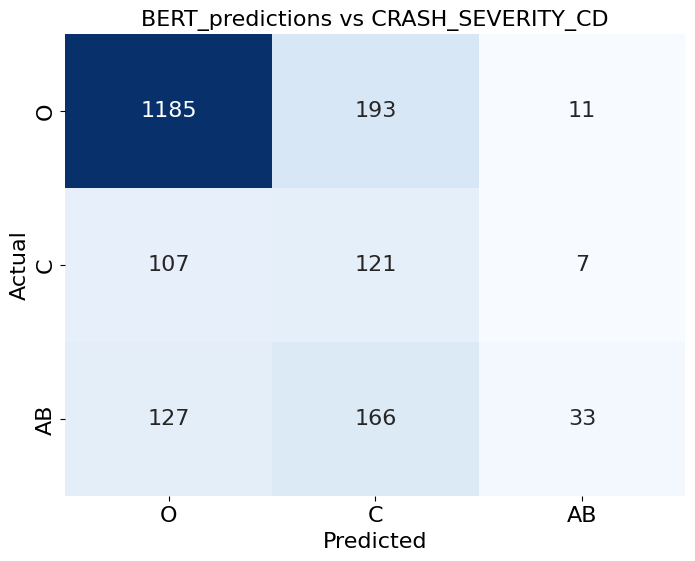

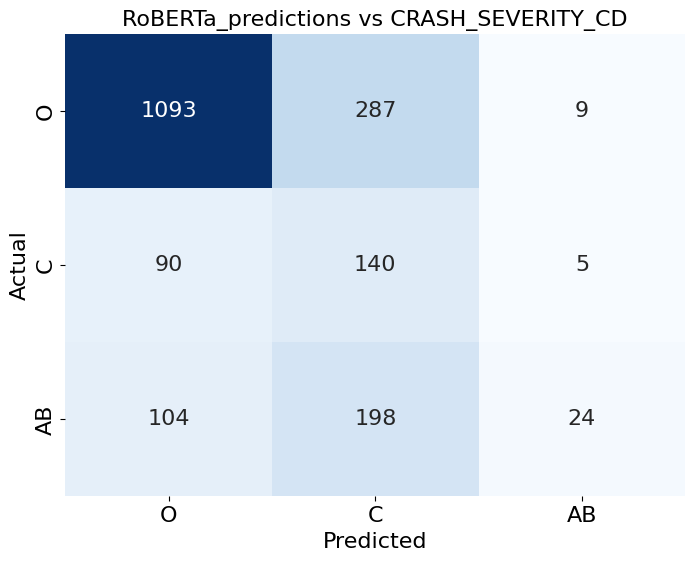

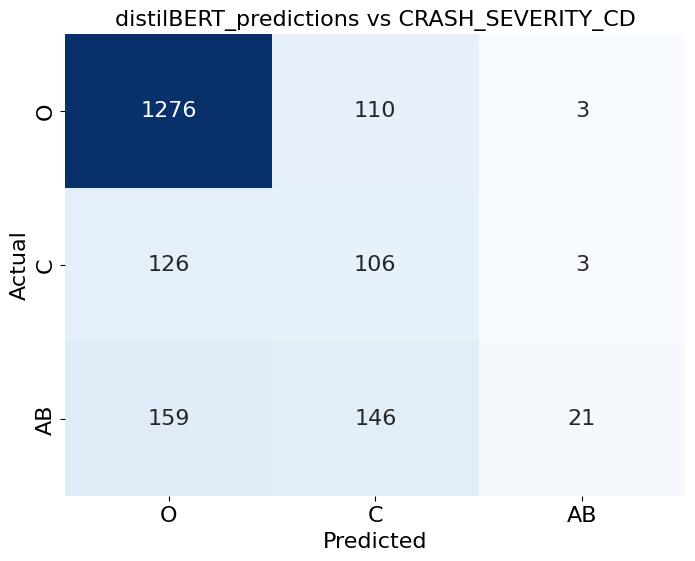

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# List of model prediction columns
prediction_columns = ['BERT_predictions', 'RoBERTa_predictions', 'distilBERT_predictions']

# Target column
target_column = 'CRASH_SEVERITY_CD'

# Specify the order of classes
class_order = ['O', 'C', 'AB']

# Loop through each model prediction column and create confusion matrix
for col in prediction_columns:
    # Create confusion matrix with specified class order
    confusion_mat = confusion_matrix(df[target_column], df[col], labels=class_order)

    # Create a DataFrame for better visualization using seaborn
    confusion_df = pd.DataFrame(confusion_mat, columns=class_order, index=class_order)
    # Plot the confusion matrix using seaborn with larger text size for annotations and class labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False,
                annot_kws={"size": 16}, cbar_kws={"label": "Count", "labelsize": 16},
                xticklabels=class_order, yticklabels=class_order)
    plt.title(f'{col} vs {target_column}', fontsize=16)
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('Actual', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Loop through each model prediction column and calculate classification report
for col in prediction_columns:
    # Calculate classification report
    class_report = classification_report(df[target_column], df[col], labels=class_order)

    # Print the classification report
    print(f'Classification Report for {col} vs {target_column}:\n\n{class_report}\n')


Classification Report for BERT_predictions vs CRASH_SEVERITY_CD:

              precision    recall  f1-score   support

           O       0.84      0.85      0.84      1389
           C       0.25      0.51      0.34       235
          AB       0.65      0.10      0.18       326

    accuracy                           0.69      1950
   macro avg       0.58      0.49      0.45      1950
weighted avg       0.73      0.69      0.67      1950


Classification Report for RoBERTa_predictions vs CRASH_SEVERITY_CD:

              precision    recall  f1-score   support

           O       0.85      0.79      0.82      1389
           C       0.22      0.60      0.33       235
          AB       0.63      0.07      0.13       326

    accuracy                           0.64      1950
   macro avg       0.57      0.49      0.42      1950
weighted avg       0.74      0.64      0.64      1950


Classification Report for distilBERT_predictions vs CRASH_SEVERITY_CD:

              precision    re

### Clouds

In [ ]:
!unzip /content/nlp-in-practice-master.zip

Archive:  /content/nlp-in-practice-master.zip
b841c04456370ac45ff5564976fdacc445d3edf0
replace nlp-in-practice-master/.gitattributes? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: nlp-in-practice-master/.gitattributes  
  inflating: nlp-in-practice-master/CountVectorizer/CountVectorizer.ipynb  
  inflating: nlp-in-practice-master/CountVectorizer/README.md  
  inflating: nlp-in-practice-master/README.md  
  inflating: nlp-in-practice-master/_config.yml  
  inflating: nlp-in-practice-master/cbow_skipgram_subword/Comparison of CBOW, SkipGram and SkipGram with Subword Information.ipynb  
  inflating: nlp-in-practice-master/cbow_skipgram_subword/README.md  
  inflating: nlp-in-practice-master/cbow_skipgram_subword/similarity_test.txt  
  inflating: nlp-in-practice-master/hashingvectorizer/HashingVectorizer.ipynb  
  inflating: nlp-in-practice-master/hashingvectorizer/README.md  
  inflating: nlp-in-practice-master/pre-trained-embeddings/Pre-trained embeddings.ipynb  
  inflating: nlp

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import re

def get_stop_words(stop_file_path):
    """load stop words """

    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_list = [m.strip() for m in stopwords]  # Convert to a list
        return stop_list

# Load a list of stop words
stopwords = get_stop_words("/content/nlp-in-practice-master/tf-idf/resources/stopwords.txt")

# Get the text column
docs = df['clean_Narrative'].tolist()

# Create a vocabulary of words,
# ignore words that appear in 85% of documents,
# eliminate stop words
cv = CountVectorizer(max_df=0.85, stop_words=stopwords)
word_count_vector = cv.fit_transform(docs)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'vis', 'viser', 'visest'] not in stop_words.
  warnings.warn(


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import re
df.dropna(subset=['clean_Narrative'], inplace=True)
def get_stop_words(stop_file_path):
    """load stop words """

    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_list = [m.strip() for m in stopwords]  # Convert to a list
        return stop_list

# Load a list of stop words
stopwords = get_stop_words("/content/nlp-in-practice-master/tf-idf/resources/stopwords.txt")

# Get the text column
docs = df['clean_Narrative'].tolist()

# Create a vocabulary of words,
# ignore words that appear in 85% of documents,
# eliminate stop words
cv = CountVectorizer(max_df=0.85, stop_words=stopwords)
word_count_vector = cv.fit_transform(docs)

cv=CountVectorizer(max_df=0.85,stop_words=stopwords,max_features=10000)
word_count_vector=cv.fit_transform(docs)
word_count_vector.shape
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=50):
    """get the feature names and tf-idf score of top n items"""

    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]

        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]

    return results
    # you only needs to do this once
feature_names=cv.get_feature_names_out()

# get the document that we want to extract keywords from
doc=docs[0]

#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())

#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,50)

# now print the results
print("\n=====Title=====")
print(docs[0])
print("\n===Keywords===")
for k in keywords:
    print(k,keywords[k])


=====Title=====
unit1 traveling center , failed stop time , rearended unit2 . driver unit1 stated hydroplaned something , brakes would stop time . unit2 also center , stopped traffic ahead .

===Keywords===
time 0.486
rearended 0.429
center 0.376
ahead 0.323
brakes 0.308
unit2 0.287
failed 0.226
traffic 0.216
stated 0.153
driver 0.137
hydroplaned 0.094
traveling 0.094


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'vis', 'viser', 'visest'] not in stop_words.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'fixed', 'head', 'object', 'vis', 'viser', 'visest'] not in stop_words.
  warnings.warn(


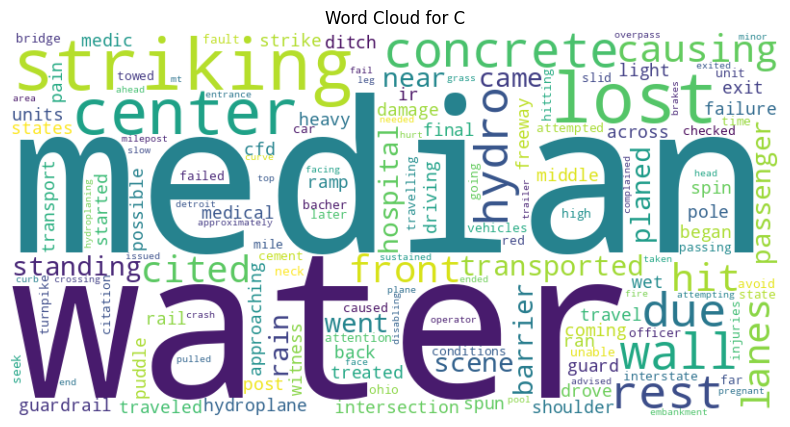

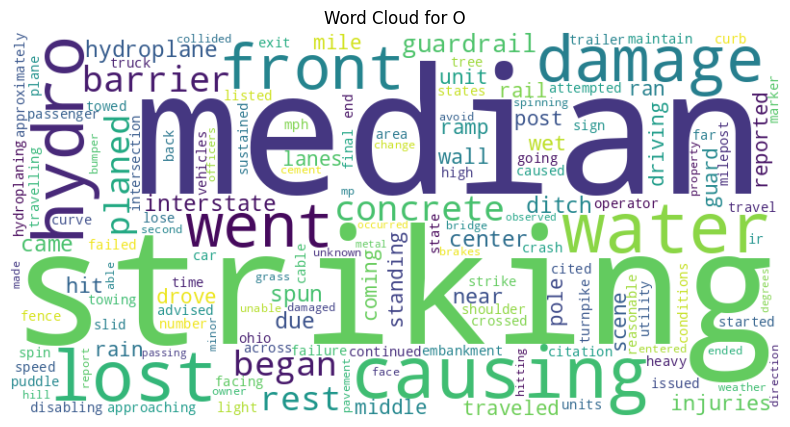

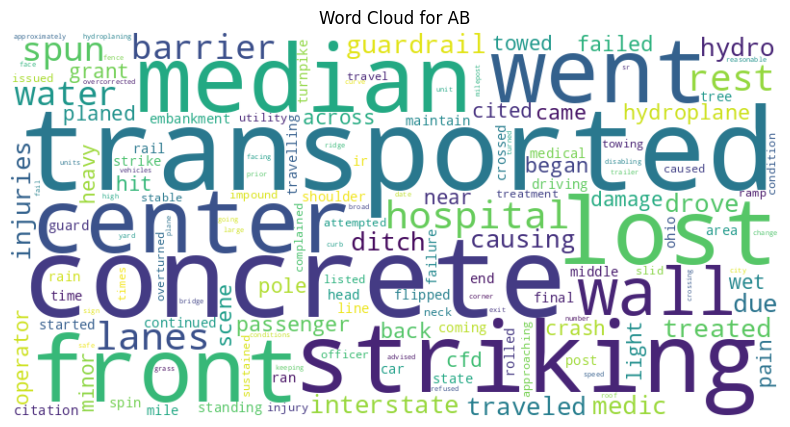

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import pandas as pd

# Assuming you have a DataFrame df with the 'clean_Narrative' and 'CRASH_SEVERITY_CD' columns already preprocessed and cleaned
df.dropna(subset=['clean_Narrative'], inplace=True)

# Load a list of stop words
def get_stop_words(stop_file_path):
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_list = [m.strip() for m in stopwords]  # Convert to a list
        return stop_list

# Define custom stop words
custom_stopwords = ['hydoplane','hydroplaned','left',"unit1", "unit2", "unit3", "unit4", "here",'traffic','roadway','drive','driver','traveling','struck','drives','accident', 'turn','backing','Head On','Fixed Object','angle','rear','stated', 'vehicle','control','side']

# Get the text column
docs = df['clean_Narrative'].tolist()

# Create a vocabulary of words, ignore words that appear in 85% of documents, eliminate stop words
cv = CountVectorizer(max_df=0.85, stop_words=stopwords + custom_stopwords, max_features=10000)
word_count_vector = cv.fit_transform(docs)

# Calculate TF-IDF scores
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(word_count_vector)

# Get feature names
feature_names = cv.get_feature_names_out()

# Create a dictionary to store the TF-IDF scores for each term
tfidf_scores = {}
for severity_level in df['CRASH_SEVERITY_CD'].unique():
    # Filter the DataFrame for the current severity level
    subset = df[df['CRASH_SEVERITY_CD'] == severity_level]

    # Combine the narrative texts for this severity level
    text = ' '.join(subset['clean_Narrative'].astype(str))

    # Generate TF-IDF for the given text
    tf_idf_vector = tfidf_transformer.transform(cv.transform([text]))

    # Sort the TF-IDF vectors by descending order of scores
    sorted_items = sort_coo(tf_idf_vector.tocoo())

    # Extract the top 50 keywords with their TF-IDF scores
    keywords = extract_topn_from_vector(feature_names, sorted_items, 150)

    # Update the TF-IDF scores dictionary with the keywords and their scores
    tfidf_scores[severity_level] = keywords

# Create word clouds for each 'CRASH_SEVERITY_CD' category
for severity_level, keywords in tfidf_scores.items():
    # Create a word cloud based on TF-IDF scores
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keywords)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {severity_level}')
    plt.axis('off')
    plt.show()


### Class Distribution

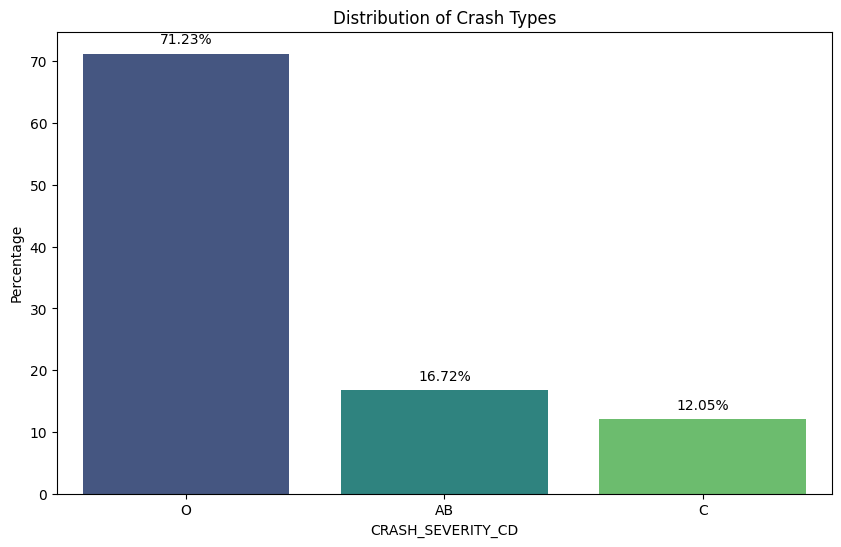

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate the percentage of each unique value in 'CRASH_TYPE_CD'
percentage_distribution = df['CRASH_SEVERITY_CD'].value_counts(normalize=True) * 100

# Plotting the distribution using seaborn with data labels
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=percentage_distribution.index, y=percentage_distribution.values, palette='viridis')

# Add data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.title('Distribution of Crash Types')
plt.xlabel('CRASH_SEVERITY_CD')
plt.ylabel('Percentage')
plt.show()


In [ ]:
'''
df['CRASH_SEVERITY_CD'] = df['CRASH_SEVERITY_CD'].replace('Fatal', 'Serious Injury Suspected') #4 classes
df['CRASH_SEVERITY_CD'] = df['CRASH_SEVERITY_CD'].replace('Injury Possible', 'Minor Injury Suspected') #3 classes
df['CRASH_SEVERITY_CD'] = df['CRASH_SEVERITY_CD'].replace('Minor Injury Suspected', 'Minor Injury ') #3 classes
df['CRASH_SEVERITY_CD'] = df['CRASH_SEVERITY_CD'].replace('Serious Injury Suspected', 'Serious Injury') #3 classes
df['CRASH_SEVERITY_CD'].value_counts()
'''

"\ndf['CRASH_SEVERITY_CD'] = df['CRASH_SEVERITY_CD'].replace('Fatal', 'Serious Injury Suspected') #4 classes\ndf['CRASH_SEVERITY_CD'] = df['CRASH_SEVERITY_CD'].replace('Injury Possible', 'Minor Injury Suspected') #3 classes\ndf['CRASH_SEVERITY_CD'] = df['CRASH_SEVERITY_CD'].replace('Minor Injury Suspected', 'Minor Injury ') #3 classes\ndf['CRASH_SEVERITY_CD'] = df['CRASH_SEVERITY_CD'].replace('Serious Injury Suspected', 'Serious Injury') #3 classes\ndf['CRASH_SEVERITY_CD'].value_counts()\n"

In [ ]:
# Combine 'Sideswipe - Passing' and 'Sideswipe - Meeting'
df['CRASH_TYPE_CD'] = df['CRASH_TYPE_CD'].replace({'Sideswipe - Passing': 'Sideswipe', 'Sideswipe - Meeting': 'Sideswipe'})

# Combine 'Left Turn' and 'Right Turn' into 'Turn'
df['CRASH_TYPE_CD'] = df['CRASH_TYPE_CD'].replace({'Left Turn': 'Turn', 'Right Turn': 'Turn'})

# Remove unwanted columns
unwanted_crash_types = ['Other Object', 'Pedalcycles', 'Unknown', 'Train', 'Other Non-Vehicle', 'Other Non-Collision', 'Overturning']
df = df[~df['CRASH_TYPE_CD'].isin(unwanted_crash_types)]

# Reset the index to avoid duplicate labels
df = df.reset_index(drop=True)

print(df['CRASH_TYPE_CD'].value_counts())


13    1296
5      283
2      133
17      88
6       56
16      28
1       18
18      16
7       10
19       8
0        5
14       4
9        2
3        2
10       1
Name: CRASH_TYPE_CD, dtype: int64


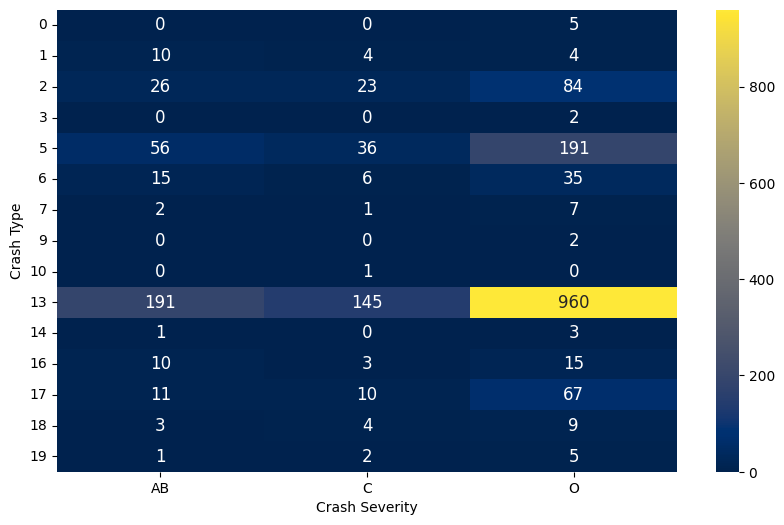

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

annot_kws = {'fontsize': 12}
# Create a cross-tabulation (contingency table)
cross_tab = pd.crosstab(df['CRASH_TYPE_CD'], df['CRASH_SEVERITY_CD'])
# Increase font size for annotations
annot_kws = {'fontsize': 12}


# Plotting a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='cividis', cbar=True,  annot_kws=annot_kws)
# Adjust x-axis labels
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=0)
plt.xlabel('Crash Severity')
plt.ylabel('Crash Type')
plt.show()


## Map

### Target

In [ ]:
df.columns

Index(['id', 'OBJECTID', 'Narrative', 'DOCUMENT_NBR', 'CRASH_YR',
       'CRASH_SEVERITY_CD', 'CRASH_MONTH_YEAR', 'DISTRICT_NBR', 'NLFID',
       'NLF_JUR_CD',
       ...
       'WEATHER_COND_CD', 'V1', 'clean_Narrative', 'BERT_predictions',
       'BERT_prediction_probabilities', 'RoBERTa_predictions',
       'RoBERTa_predictions_probabilities', 'distilBERT_predictions',
       'distilBERT_predictions_probabilities', 'CRASH_YEAR'],
      dtype='object', length=159)

In [ ]:
print(df[['NLF_COUNTY_CD', 'ODOT_LATITUDE_NBR', 'ODOT_LONGITUDE_NBR']].head())


  NLF_COUNTY_CD  ODOT_LATITUDE_NBR  ODOT_LONGITUDE_NBR
0           HAM          39.098680          -84.509164
1           FRA          40.038506          -82.996940
2           HUR          41.273302          -82.442447
3           CUY          41.470934          -81.816463
4           CUY          41.425877          -81.759509


In [ ]:
df['NLF_COUNTY_CD'].value_counts()

CUY    254
HAM    233
FRA    226
SUM    159
MOT     82
      ... 
HIG      1
HAS      1
NOB      1
DEF      1
GEA      1
Name: NLF_COUNTY_CD, Length: 78, dtype: int64

In [ ]:
import folium
from folium.plugins import HeatMap
import json
from shapely.geometry import shape, MultiPolygon

# Load the GeoJSON file for Ohio counties
geojson_path_counties = '/content/USA_Counties_(Generalized).geojson'
with open(geojson_path_counties) as f:
    geojson_data_counties = json.load(f)

# Filter Ohio counties
ohio_counties = [feature for feature in geojson_data_counties['features'] if feature['properties']['STATE_NAME'] == 'Ohio']

# Create a mask for the entire state of Ohio
state_mask = MultiPolygon([shape(feature['geometry']) for feature in ohio_counties])

# Filter crash points within the state boundaries
df['within_state'] = df.apply(lambda row: state_mask.contains(shape(Point(row['ODOT_LONGITUDE_NBR'], row['ODOT_LATITUDE_NBR']))), axis=1)
filtered_df = df[df['within_state']]

# Choose a location for the center of the map based on Ohio counties
map_center = [39.5, -82.5]  # Update with appropriate coordinates for the center of Ohio

# Create a folium map
m = folium.Map(location=map_center, zoom_start=7, tiles=None)

# Add Ohio counties to the map
for feature in ohio_counties:
    coordinates = feature['geometry']['coordinates']
    folium.GeoJson(
        feature,
        name='geojson_counties',
        style_function=lambda x: {'fillColor': 'black', 'color': 'black', 'weight': .5, 'fillOpacity': 0.01}
    ).add_to(m)

# Create a HeatMap layer based on the filtered crash points
heat_data = filtered_df[['ODOT_LATITUDE_NBR', 'ODOT_LONGITUDE_NBR']].dropna().values
HeatMap(heat_data, radius=15, blur=10).add_to(m)

# Display the map in the notebook
m


In [ ]:
import folium
import json
from shapely.geometry import shape, MultiPolygon
from shapely.geometry.point import Point

# Load the GeoJSON file for Ohio counties
geojson_path_counties = '/content/USA_Counties_(Generalized).geojson'
with open(geojson_path_counties) as f:
    geojson_data_counties = json.load(f)

# Filter Ohio counties
ohio_counties = [feature for feature in geojson_data_counties['features'] if feature['properties']['STATE_NAME'] == 'Ohio']

# Create a mask for the entire state of Ohio
state_mask = MultiPolygon([shape(feature['geometry']) for feature in ohio_counties])

# Choose a location for the center of the map based on Ohio counties
map_center = [39.5, -82.5]  # Update with appropriate coordinates for the center of Ohio

# Create a folium map
m = folium.Map(location=map_center, zoom_start=7, tiles=None)

# Add Ohio counties outlines with names
for feature in ohio_counties:
    coordinates = feature['geometry']['coordinates']
    centroid = MultiPolygon([shape(feature['geometry'])]).centroid
    county_name = feature['properties']['NAME']

    # Create GeoJson layer for the county outlines
    folium.GeoJson(
        feature,
        name='geojson_counties',
        style_function=lambda x: {'color': 'black', 'weight': 1}
    ).add_to(m)

    # Add text label within each county
    folium.Marker(
        [centroid.y, centroid.x],
        popup=county_name,
        icon=folium.DivIcon(html=f"<div style='color: black;'>{county_name}</div>")
    ).add_to(m)

# Display the map in the notebook
m


In [ ]:
import folium
import json
'''
#All county boundies
# Load the GeoJSON file
geojson_path = '/content/USA_Counties_(Generalized).geojson'

# Read the GeoJSON file
with open(geojson_path) as f:
    geojson_data = json.load(f)

# Filter Ohio counties
ohio_counties = [feature for feature in geojson_data['features'] if feature['properties']['STATE_NAME'] == 'Ohio']

# Choose a location for the center of the map based on Ohio counties
map_center = [39.5, -82.5]  # Update with appropriate coordinates for the center of Ohio

# Create a folium map
m = folium.Map(location=map_center, zoom_start=7)

# Add Ohio counties to the map
for feature in ohio_counties:
    coordinates = feature['geometry']['coordinates']
    folium.GeoJson(
        feature,
        name='geojson',
        style_function=lambda x: {'fillColor': 'orange', 'color': 'black', 'weight': 1, 'fillOpacity': 0.6}
    ).add_to(m)

# Display the map in the notebook
m
'''

"\n#All county boundies\n# Load the GeoJSON file\ngeojson_path = '/content/USA_Counties_(Generalized).geojson'\n\n# Read the GeoJSON file\nwith open(geojson_path) as f:\n    geojson_data = json.load(f)\n\n# Filter Ohio counties\nohio_counties = [feature for feature in geojson_data['features'] if feature['properties']['STATE_NAME'] == 'Ohio']\n\n# Choose a location for the center of the map based on Ohio counties\nmap_center = [39.5, -82.5]  # Update with appropriate coordinates for the center of Ohio\n\n# Create a folium map\nm = folium.Map(location=map_center, zoom_start=7)\n\n# Add Ohio counties to the map\nfor feature in ohio_counties:\n    coordinates = feature['geometry']['coordinates']\n    folium.GeoJson(\n        feature,\n        name='geojson',\n        style_function=lambda x: {'fillColor': 'orange', 'color': 'black', 'weight': 1, 'fillOpacity': 0.6}\n    ).add_to(m)\n\n# Display the map in the notebook\nm\n"

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load the GeoJSON file
geojson_path = '/content/USA_Counties_(Generalized).geojson'
with open(geojson_path) as f:
    geojson_data = json.load(f)

# Filter Ohio counties
ohio_counties = [feature for feature in geojson_data['features'] if feature['properties']['STATE_NAME'] == 'Ohio']

# Create a GeoDataFrame from the Ohio counties GeoJSON
gdf_counties = gpd.GeoDataFrame.from_features(ohio_counties)

# Use the centroid of each county polygon as a representative point
gdf_counties['centroid'] = gdf_counties['geometry'].centroid

# Create a GeoDataFrame from the DataFrame with Point geometries
gdf_points = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['ODOT_LONGITUDE_NBR'], df['ODOT_LATITUDE_NBR']))

# Perform a spatial join to determine which county each point falls within
merged_gdf = gpd.sjoin(gdf_points, gdf_counties, how='left', op='within')

# Add a new column 'county_id' to the original DataFrame
df['county_id'] = merged_gdf['FID']  # Use 'FID' as the county identifier

# Display the resulting DataFrame with the new 'county_id' column
print(df[['ODOT_LONGITUDE_NBR', 'ODOT_LATITUDE_NBR', 'county_id']])



      ODOT_LONGITUDE_NBR  ODOT_LATITUDE_NBR  county_id
0             -84.509164          39.098680     2861.0
1             -82.996940          40.038506     2855.0
2             -82.442447          41.273302     2869.0
3             -81.816463          41.470934     2848.0
4             -81.759509          41.425877     2848.0
...                  ...                ...        ...
1945          -84.223452          39.714216     2887.0
1946          -84.154800          39.754390     2887.0
1947          -82.363309          40.062807     2875.0
1948          -82.377363          40.063549     2875.0
1949          -83.604076          41.550615     2917.0

[1950 rows x 3 columns]


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



In [ ]:
# Group by 'county_id' and find the mode (most common crash type) for each group
most_common_crash_type_per_county = df.groupby('county_id')['CRASH_SEVERITY_CD'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Rename the columns for clarity
most_common_crash_type_per_county.columns = ['county_id', 'most_common_crash_type']

# Display the resulting DataFrame
print(most_common_crash_type_per_county)


    county_id most_common_crash_type
0      2831.0                      O
1      2832.0                      O
2      2833.0                      O
3      2834.0                      O
4      2835.0                      O
..        ...                    ...
72     2913.0                      O
73     2914.0                      O
74     2915.0                      O
75     2916.0                      O
76     2917.0                      O

[77 rows x 2 columns]


In [ ]:
import folium
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Assuming most_common_crash_type_per_county contains the DataFrame
# generated from the code you provided earlier

# Load the GeoJSON file
geojson_path = '/content/USA_Counties_(Generalized).geojson'
with open(geojson_path) as f:
    geojson_data = json.load(f)

# Filter Ohio counties
ohio_counties = [feature for feature in geojson_data['features'] if feature['properties']['STATE_NAME'] == 'Ohio']

# Create a GeoDataFrame from the Ohio counties GeoJSON
gdf_counties = gpd.GeoDataFrame.from_features(ohio_counties)

# Merge GeoDataFrame of counties with DataFrame of most common crash types
gdf_merged = gdf_counties.merge(most_common_crash_type_per_county, left_on='FID', right_on='county_id', how='left')

# Choose a location for the center of the map based on Ohio counties
map_center = [39.5, -82.5]  # Update with appropriate coordinates for the center of Ohio

# Create a folium map
m = folium.Map(location=map_center, zoom_start=7)

# Add one point for each county with its most frequent crash type
for _, row in gdf_merged.iterrows():
    county_geometry = row['geometry']
    county_id = row['FID']
    most_common_crash_type = row['most_common_crash_type']

    # Define a colormap for crash types
    colormap = {
        'O': 'blue',
        'C': 'green',
        'AB': 'red',
        # Add more crash types and colors as needed
    }

    # Set the fill color based on the most common crash type
    fill_color = colormap.get(most_common_crash_type, 'gray')

    # Use the centroid of the county geometry for the marker location
    coordinates = county_geometry.centroid.xy

    # Add a marker for each county
    folium.Marker(
        location=[coordinates[1][0], coordinates[0][0]],  # latitude, longitude
        popup=f"County ID: {county_id}<br>Most Common Crash Type: {most_common_crash_type}",
        icon=folium.Icon(color=fill_color)
    ).add_to(m)

# Display the map in the notebook
m


In [ ]:
import folium
from folium.plugins import FloatImage
import json

# Assuming most_common_crash_type_per_county contains the DataFrame
# generated from the code you provided earlier

# Load the GeoJSON file
geojson_path = '/content/USA_Counties_(Generalized).geojson'
with open(geojson_path) as f:
    geojson_data = json.load(f)

# Filter Ohio counties
ohio_counties = [feature for feature in geojson_data['features'] if feature['properties']['STATE_NAME'] == 'Ohio']

# Choose a location for the center of the map based on Ohio counties
map_center = [39.5, -82.5]  # Update with appropriate coordinates for the center of Ohio

# Create a folium map
m = folium.Map(location=map_center, zoom_start=7)

# Merge GeoDataFrame of counties with DataFrame of most common crash types
gdf_merged = gdf_counties.merge(most_common_crash_type_per_county, left_on='FID', right_on='county_id', how='left')

# Define a colormap for crash types
colormap = {
    'O': 'blue',
    'C': 'green',
    'AB': 'red',
}

# Add Ohio counties to the map with colors based on most common crash type
for feature in ohio_counties:
    county_id = feature['properties']['FID']
    county_data = gdf_merged[gdf_merged['FID'] == county_id]
    most_common_crash_type = county_data['most_common_crash_type'].iloc[0] if not county_data.empty else 'No samples'

    # Set the fill color based on the most common crash type
    fill_color = colormap.get(most_common_crash_type, 'gray')

    folium.GeoJson(
        feature,
        name='geojson',
        style_function=lambda x, fill_color=fill_color: {'fillColor': fill_color, 'color': 'black', 'weight': 1, 'fillOpacity': 0.6}
    ).add_to(m)

# Create a legend
legend_html = '''
     <div style="position: fixed;
                 bottom: 50px; left: 50px; width: 150px; height: 150px;
                 border:2px solid grey; z-index:9999; font-size:18px;
                 background-color:white; opacity:0.9;">
     &nbsp; <b>Legend</b> <br>
     &nbsp; Type O &nbsp; <i class="fa fa-square"
                             style="color:blue"></i><br>
     &nbsp; Type C &nbsp; <i class="fa fa-square"
                             style="color:green"></i><br>
     &nbsp; Type AB &nbsp; <i class="fa fa-square"
                              style="color:red"></i><br>
     &nbsp; No samples &nbsp; <i class="fa fa-square"
                                style="color:gray"></i><br>
     </div>
     '''

m.get_root().html.add_child(folium.Element(legend_html))

# Display the map in the notebook
m


Average Anual Precipitation
https://media.cocorahs.org/images/Composite-OH-1100w.png

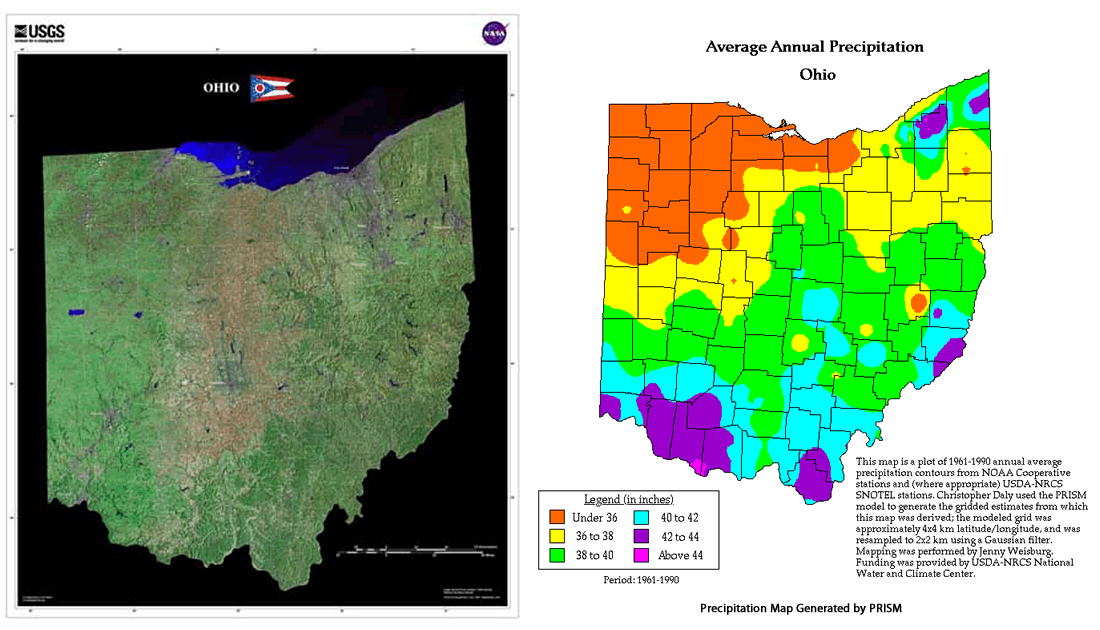

### Prediction

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load the GeoJSON file
geojson_path = '/content/USA_Counties_(Generalized).geojson'
with open(geojson_path) as f:
    geojson_data = json.load(f)

# Filter Ohio counties
ohio_counties = [feature for feature in geojson_data['features'] if feature['properties']['STATE_NAME'] == 'Ohio']

# Create a GeoDataFrame from the Ohio counties GeoJSON
gdf_counties = gpd.GeoDataFrame.from_features(ohio_counties)

# Use the centroid of each county polygon as a representative point
gdf_counties['centroid'] = gdf_counties['geometry'].centroid

# Create a GeoDataFrame from the DataFrame with Point geometries
gdf_points = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['ODOT_LONGITUDE_NBR'], df['ODOT_LATITUDE_NBR']))

# Perform a spatial join to determine which county each point falls within
merged_gdf = gpd.sjoin(gdf_points, gdf_counties, how='left', op='within')

# Add a new column 'county_id' to the original DataFrame
df['county_id'] = merged_gdf['FID']  # Use 'FID' as the county identifier

# Display the resulting DataFrame with the new 'county_id' column
print(df[['ODOT_LONGITUDE_NBR', 'ODOT_LATITUDE_NBR', 'county_id']])



      ODOT_LONGITUDE_NBR  ODOT_LATITUDE_NBR  county_id
0             -84.509164          39.098680     2861.0
1             -82.996940          40.038506     2855.0
2             -82.442447          41.273302     2869.0
3             -81.816463          41.470934     2848.0
4             -81.759509          41.425877     2848.0
...                  ...                ...        ...
1945          -84.223452          39.714216     2887.0
1946          -84.154800          39.754390     2887.0
1947          -82.363309          40.062807     2875.0
1948          -82.377363          40.063549     2875.0
1949          -83.604076          41.550615     2917.0

[1950 rows x 3 columns]


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



In [ ]:
# Group by 'county_id' and find the mode (most common crash type) for each group
most_common_crash_type_per_county = df.groupby('county_id')['distilBERT_predictions'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Rename the columns for clarity
most_common_crash_type_per_county.columns = ['county_id', 'most_common_crash_type']

# Display the resulting DataFrame
print(most_common_crash_type_per_county)


    county_id most_common_crash_type
0      2831.0                      O
1      2832.0                      O
2      2833.0                      O
3      2834.0                      O
4      2835.0                      O
..        ...                    ...
72     2913.0                      O
73     2914.0                      O
74     2915.0                      O
75     2916.0                      O
76     2917.0                      O

[77 rows x 2 columns]


In [ ]:
import folium
from folium.plugins import FloatImage
import json

# Assuming most_common_crash_type_per_county contains the DataFrame
# generated from the code you provided earlier

# Load the GeoJSON file
geojson_path = '/content/USA_Counties_(Generalized).geojson'
with open(geojson_path) as f:
    geojson_data = json.load(f)

# Filter Ohio counties
ohio_counties = [feature for feature in geojson_data['features'] if feature['properties']['STATE_NAME'] == 'Ohio']

# Choose a location for the center of the map based on Ohio counties
map_center = [39.5, -82.5]  # Update with appropriate coordinates for the center of Ohio

# Create a folium map
m = folium.Map(location=map_center, zoom_start=7)

# Merge GeoDataFrame of counties with DataFrame of most common crash types
gdf_merged = gdf_counties.merge(most_common_crash_type_per_county, left_on='FID', right_on='county_id', how='left')

# Define a colormap for crash types
colormap = {
    'O': 'blue',
    'C': 'green',
    'AB': 'red',
}

# Add Ohio counties to the map with colors based on most common crash type
for feature in ohio_counties:
    county_id = feature['properties']['FID']
    county_data = gdf_merged[gdf_merged['FID'] == county_id]
    most_common_crash_type = county_data['most_common_crash_type'].iloc[0] if not county_data.empty else 'No samples'

    # Set the fill color based on the most common crash type
    fill_color = colormap.get(most_common_crash_type, 'gray')

    folium.GeoJson(
        feature,
        name='geojson',
        style_function=lambda x, fill_color=fill_color: {'fillColor': fill_color, 'color': 'black', 'weight': 1, 'fillOpacity': 0.6}
    ).add_to(m)

# Create a legend
legend_html = '''
     <div style="position: fixed;
                 bottom: 50px; left: 50px; width: 150px; height: 150px;
                 border:2px solid grey; z-index:9999; font-size:18px;
                 background-color:white; opacity:0.9;">
     &nbsp; <b>Legend</b> <br>
     &nbsp; Type O &nbsp; <i class="fa fa-square"
                             style="color:blue"></i><br>
     &nbsp; Type C &nbsp; <i class="fa fa-square"
                             style="color:green"></i><br>
     &nbsp; Type AB &nbsp; <i class="fa fa-square"
                              style="color:red"></i><br>
     &nbsp; No samples &nbsp; <i class="fa fa-square"
                                style="color:gray"></i><br>
     </div>
     '''

m.get_root().html.add_child(folium.Element(legend_html))

# Display the map in the notebook
m
